In [2]:
#TODO: import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import os
import re
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import glob
from tqdm import tqdm
from numba import cuda

from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time

In [150]:
batch_size = 64
max_len = 32

# 1.Data Preprocessing

## a. Data retrieval

In [347]:
datasets = {}

In [348]:
# Abuse Detection Dataset 1 - OffenseEval
datasets['OffenseEval'] = pd.DataFrame({'words':pd.Series([], dtype = 'string'),
                                        'abusive_flag':pd.Series([], dtype = 'int64')
                                       })
for key in load_dataset("christophsonntag/OLID").keys():
    df_raw = load_dataset("christophsonntag/OLID")[key].to_pandas()
    df_clean = df_raw[['cleaned_tweet','subtask_a']].rename(columns = {'cleaned_tweet': 'words',
                                                                       'subtask_a':'abusive_flag'})\
                                                    .replace({'OFF': 1, 'NOT': 0})  
    datasets['OffenseEval'] = pd.concat([datasets['OffenseEval'], df_clean], ignore_index = True)

/tmp/ipykernel_527648/2410557440.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'OFF': 1, 'NOT': 0})
/tmp/ipykernel_527648/2410557440.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'OFF': 1, 'NOT': 0})


In [349]:
datasets['OffenseEval'].dtypes

words           object
abusive_flag     int64
dtype: object

In [350]:
word_counts = datasets['OffenseEval'].groupby(['abusive_flag']).count()
word_percentile = word_counts / word_counts.sum() * 100


In [351]:
word_percentile

,words
abusive_flag,
0,66.956522
1,33.043478


In [352]:
# Abuse Detection Dataset 2 - HateXplain
datasets['HateXplain'] = pd.DataFrame({'tokens':pd.Series([], dtype = 'string'),
                                        'offensive_flag':pd.Series([], dtype = 'int64')
                                       })


for key in load_dataset("Hate-speech-CNERG/hatexplain").keys():
    df_raw = load_dataset("Hate-speech-CNERG/hatexplain")[key].to_pandas()
    
    
    annotators = df_raw['annotators'].apply(pd.Series)
    labels = annotators['label'].apply(pd.Series)
    offensive_flag = []
    for i in range(len(labels)):
        offensive_counts = 0
        for j in [0,1,2]:
            if labels.iloc[i,j] == 2: # reference https://huggingface.co/datasets/Hate-speech-CNERG/hatexplain
                offensive_counts+=1
        if offensive_counts > 0:
            offensive_flag.append(1)
        else:
            offensive_flag.append(0)
    df_raw['offensive_flag'] = offensive_flag
    df_clean = df_raw[['post_tokens','offensive_flag']].rename(columns = {'post_tokens': 'tokens'})        
    datasets['HateXplain'] = pd.concat([datasets['HateXplain'], df_clean], ignore_index = True)

In [353]:
datasets['HateXplain'].groupby(['offensive_flag']).count()

,tokens
offensive_flag,
0,9464
1,9765


In [354]:
cd SemEval18/Task 1

/home/jupyter-lip214/Final Project/SemEval18/Task 1


In [355]:
# Emotion Detection Dataset - SemEval18
files = ["2018-E-c-En-train.txt", "2018-E-c-En-dev.txt"]
dfs = []
for fn in files:
    # if your .txt *does* have a header row, just drop names=... 
    df = pd.read_csv(fn, sep="\t", header=0)
    dfs.append(df)
datasets['SemEval18_Task1'] = pd.concat(dfs, ignore_index=True)

emotion_cols = [
    "anger","anticipation","disgust","fear","joy",
    "love","optimism","pessimism","sadness","surprise","trust"
]
# Make sure they’re ints (0/1)
datasets['SemEval18_Task1'][emotion_cols] = datasets['SemEval18_Task1'][emotion_cols].astype(int)

# Create a multi-hot label array per row:
def get_multi_hot(row):
    return row[emotion_cols].values.astype(int)  # shape (11,)

datasets['SemEval18_Task1']["emotion_labels"] = datasets['SemEval18_Task1'] .apply(get_multi_hot, axis=1)

datasets['SemEval18_Task1']  = datasets['SemEval18_Task1'] [['Tweet', 'emotion_labels']]\
                         .rename(columns = {'Tweet': 'words'})

In [356]:
datasets['SemEval18_Task1'].head()

,words,emotion_labels
0,“Worry is a down payment on a problem you may ...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [357]:
cd ..

/home/jupyter-lip214/Final Project/SemEval18


In [358]:
cd Task 3

/home/jupyter-lip214/Final Project/SemEval18/Task 3


In [359]:
files = ["SemEval2018-T3-train-taskA.txt"]
dfs = []
for fn in files:
    # if your .txt *does* have a header row, just drop names=... 
    df = pd.read_csv(fn, sep="\t", header=0)
    dfs.append(df)
datasets['SemEval18_Task3'] = pd.concat(dfs, ignore_index=True)[['Tweet text', 'Label']].rename(columns = {'Tweet text': 'words',
                                                                                                           'Label':'ironic_flag'})

In [360]:
datasets['SemEval18_Task3'].head()

,words,ironic_flag
0,Sweet United Nations video. Just in time for C...,1
1,@mrdahl87 We are rumored to have talked to Erv...,1
2,Hey there! Nice to see you Minnesota/ND Winter...,1
3,3 episodes left I'm dying over here,0
4,I can't breathe! was chosen as the most notabl...,1


In [363]:
for key, value in datasets.items():
    print(key)

OffenseEval
HateXplain
SemEval18_Task1
SemEval18_Task3


## b. Text normalization

In [365]:
# drop null and r
for key, value in datasets.items():
    if key != 'HateXplain': # the HateXplain data has already been normalized and tokenized
        datasets [key]= datasets[key].dropna(subset=['words'])

# Function to clean curly quotes
def remove_curly_quotes(text):
    text = text.replace('‘', '').replace('’', '').replace('“', '').replace('”', '')
    return text
# Apply the function to the 'words' column
for key, value in datasets.items():
    if key != 'HateXplain': # the HateXplain data has already been normalized and tokenized
        datasets[key]["words"] =  datasets[key]["words"].apply(remove_curly_quotes)


def normalize_tweet(text):
    MENTION = r'@\w+'
    URL = r'https?://\S+'
    HASHTAG = r'#(\w+)'
    
    # Remove single and double quotes
    text = re.sub(r'[\'"]', '', text)  # This removes both single and double quotes from the entire text
    
    text = text.lower()
    text = re.sub(MENTION, ' MTN ', text)
    text = re.sub(URL, ' URL ', text)
    text = re.sub(HASHTAG, r'\1', text)
    return text.strip()


# Apply normalization
for key, value in datasets.items():
    if key != 'HateXplain': # the HateXplain data has already been normalized and tokenized
        df = datasets[key].copy()
        datasets[key]["normalized_words"] = df["words"].apply(normalize_tweet)

In [223]:
datasets['OffenseEval'].head()

,words,abusive_flag,normalized_words
0,ask native americans take,1,ask native americans take
1,go home drunk maga trump 2020,1,go home drunk maga trump 2020
2,amazon investigating chinese employees selling...,0,amazon investigating chinese employees selling...
3,someone vetaken piece shit volcano,1,someone vetaken piece shit volcano
4,obama wanted liberals illegals move red states,0,obama wanted liberals illegals move red states


In [366]:
datasets['HateXplain'].head()

,tokens,offensive_flag
0,"[u, really, think, i, would, not, have, been, ...",1
1,"[the, uk, has, threatened, to, return, radioac...",1
2,"[if, english, is, not, imposition, then, hindi...",1
3,"[no, liberal, congratulated, hindu, refugees, ...",1
4,"[he, said, bro, even, your, texts, sound, redn...",1


In [224]:
datasets['SemEval18_Task1'].head()

,words,emotion_labels,normalized_words
0,Worry is a down payment on a problem you may n...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]",worry is a down payment on a problem you may n...
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",whatever you decide to do make sure it makes y...
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]",MTN it also helps that the majority of nfl c...
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]",accept the challenges so that you can literall...
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",my roommate: its okay that we cant spell becau...


In [225]:
datasets['SemEval18_Task3'].head()

,words,ironic_flag,normalized_words
0,Sweet United Nations video. Just in time for C...,1,sweet united nations video. just in time for c...
1,@mrdahl87 We are rumored to have talked to Erv...,1,MTN we are rumored to have talked to ervs age...
2,Hey there! Nice to see you Minnesota/ND Winter...,1,hey there! nice to see you minnesota/nd winter...
3,3 episodes left I'm dying over here,0,3 episodes left im dying over here
4,I can't breathe! was chosen as the most notabl...,1,i cant breathe! was chosen as the most notable...


## c. Tokenize the normalized text

In [368]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(preserve_case=False)

# Apply tokenizer
for key, value in datasets.items():
    if key != 'HateXplain': # the HateXplain data has already been normalized and tokenized
        datasets[key]["tokens"] = datasets[key]["normalized_words"].apply(tokenizer.tokenize)

In [370]:
datasets['OffenseEval'].head()

,words,abusive_flag,normalized_words,tokens
0,ask native americans take,1,ask native americans take,"[ask, native, americans, take]"
1,go home drunk maga trump 2020,1,go home drunk maga trump 2020,"[go, home, drunk, maga, trump, 2020]"
2,amazon investigating chinese employees selling...,0,amazon investigating chinese employees selling...,"[amazon, investigating, chinese, employees, se..."
3,someone vetaken piece shit volcano,1,someone vetaken piece shit volcano,"[someone, vetaken, piece, shit, volcano]"
4,obama wanted liberals illegals move red states,0,obama wanted liberals illegals move red states,"[obama, wanted, liberals, illegals, move, red,..."


In [371]:
datasets['HateXplain'].head()

,tokens,offensive_flag
0,"[u, really, think, i, would, not, have, been, ...",1
1,"[the, uk, has, threatened, to, return, radioac...",1
2,"[if, english, is, not, imposition, then, hindi...",1
3,"[no, liberal, congratulated, hindu, refugees, ...",1
4,"[he, said, bro, even, your, texts, sound, redn...",1


In [372]:
datasets['SemEval18_Task1'].head()

,words,emotion_labels,normalized_words,tokens
0,Worry is a down payment on a problem you may n...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]",worry is a down payment on a problem you may n...,"[worry, is, a, down, payment, on, a, problem, ..."
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",whatever you decide to do make sure it makes y...,"[whatever, you, decide, to, do, make, sure, it..."
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]",MTN it also helps that the majority of nfl c...,"[mtn, it, also, helps, that, the, majority, of..."
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]",accept the challenges so that you can literall...,"[accept, the, challenges, so, that, you, can, ..."
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",my roommate: its okay that we cant spell becau...,"[my, roommate, :, its, okay, that, we, cant, s..."


In [373]:
datasets['SemEval18_Task3'].head()

,words,ironic_flag,normalized_words,tokens
0,Sweet United Nations video. Just in time for C...,1,sweet united nations video. just in time for c...,"[sweet, united, nations, video, ., just, in, t..."
1,@mrdahl87 We are rumored to have talked to Erv...,1,MTN we are rumored to have talked to ervs age...,"[mtn, we, are, rumored, to, have, talked, to, ..."
2,Hey there! Nice to see you Minnesota/ND Winter...,1,hey there! nice to see you minnesota/nd winter...,"[hey, there, !, nice, to, see, you, minnesota,..."
3,3 episodes left I'm dying over here,0,3 episodes left im dying over here,"[3, episodes, left, im, dying, over, here]"
4,I can't breathe! was chosen as the most notabl...,1,i cant breathe! was chosen as the most notable...,"[i, cant, breathe, !, was, chosen, as, the, mo..."


## d. Embedding

In [374]:
import gensim.downloader as api

In [22]:
glove = api.load('glove-wiki-gigaword-300')

In [375]:
import numpy as np

# Assume glove_vocab is a dict: word -> 300-dim vector

def sentence_to_embeddings(tokens, glove, embed_dim=300):
    embeddings = []
    for token in tokens:
        if token in glove:
            embeddings.append(glove[token])
        else:
            embeddings.append([0.0] * embed_dim)  # handle OOV (out of vocab)
    return embeddings


In [376]:
# Apply embedding
for key, value in datasets.items():
    datasets[key]["glove_embeddings"] = datasets[key]["tokens"].apply(lambda tokens: sentence_to_embeddings(tokens, glove))

In [377]:
datasets['OffenseEval'].head()

,words,abusive_flag,normalized_words,tokens,glove_embeddings
0,ask native americans take,1,ask native americans take,"[ask, native, americans, take]","[[-0.16576, -0.12557, -0.38942, -0.086341, 0.1..."
1,go home drunk maga trump 2020,1,go home drunk maga trump 2020,"[go, home, drunk, maga, trump, 2020]","[[0.0073678, 0.062532, -0.097432, 0.28289, 0.1..."
2,amazon investigating chinese employees selling...,0,amazon investigating chinese employees selling...,"[amazon, investigating, chinese, employees, se...","[[-0.123, 0.059978, -0.18989, 0.27987, -0.0289..."
3,someone vetaken piece shit volcano,1,someone vetaken piece shit volcano,"[someone, vetaken, piece, shit, volcano]","[[-0.65558, 0.19155, -0.22808, 0.077055, -0.40..."
4,obama wanted liberals illegals move red states,0,obama wanted liberals illegals move red states,"[obama, wanted, liberals, illegals, move, red,...","[[0.10303, 0.48005, -0.50917, 0.142, -0.58965,..."


In [378]:
datasets['HateXplain'].head()

,tokens,offensive_flag,glove_embeddings
0,"[u, really, think, i, would, not, have, been, ...",1,"[[0.016393, -0.40067, -0.26541, -0.43166, -1.0..."
1,"[the, uk, has, threatened, to, return, radioac...",1,"[[0.04656, 0.21318, -0.0074364, -0.45854, -0.0..."
2,"[if, english, is, not, imposition, then, hindi...",1,"[[-0.23365, 0.35933, -0.068678, -0.10677, 0.07..."
3,"[no, liberal, congratulated, hindu, refugees, ...",1,"[[-0.16843, -0.037651, -0.17304, -0.069757, -0..."
4,"[he, said, bro, even, your, texts, sound, redn...",1,"[[-0.52057, 0.49562, 0.032912, -0.060807, -0.0..."


In [379]:
datasets['SemEval18_Task1'].head()

,words,emotion_labels,normalized_words,tokens,glove_embeddings
0,Worry is a down payment on a problem you may n...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]",worry is a down payment on a problem you may n...,"[worry, is, a, down, payment, on, a, problem, ...","[[0.04441, 0.016501, 0.15928, 0.20976, 0.05974..."
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",whatever you decide to do make sure it makes y...,"[whatever, you, decide, to, do, make, sure, it...","[[-0.062355, -0.1736, -0.11689, 0.058081, -0.0..."
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]",MTN it also helps that the majority of nfl c...,"[mtn, it, also, helps, that, the, majority, of...","[[-0.539, 0.47283, 0.07349, 0.42509, 0.56494, ..."
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]",accept the challenges so that you can literall...,"[accept, the, challenges, so, that, you, can, ...","[[0.33193, 0.094913, 0.14778, -0.1492, -0.3301..."
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",my roommate: its okay that we cant spell becau...,"[my, roommate, :, its, okay, that, we, cant, s...","[[-0.22746, -0.13658, -0.38997, -0.014499, -0...."


In [380]:
datasets['SemEval18_Task3'].head()

,words,ironic_flag,normalized_words,tokens,glove_embeddings
0,Sweet United Nations video. Just in time for C...,1,sweet united nations video. just in time for c...,"[sweet, united, nations, video, ., just, in, t...","[[-0.68296, -0.064358, 0.62038, -0.11316, -0.5..."
1,@mrdahl87 We are rumored to have talked to Erv...,1,MTN we are rumored to have talked to ervs age...,"[mtn, we, are, rumored, to, have, talked, to, ...","[[-0.539, 0.47283, 0.07349, 0.42509, 0.56494, ..."
2,Hey there! Nice to see you Minnesota/ND Winter...,1,hey there! nice to see you minnesota/nd winter...,"[hey, there, !, nice, to, see, you, minnesota,...","[[-0.28344, -0.43463, -0.29527, 0.66427, -0.42..."
3,3 episodes left I'm dying over here,0,3 episodes left im dying over here,"[3, episodes, left, im, dying, over, here]","[[-0.34294, 0.146, -0.1963, 0.12843, -0.46988,..."
4,I can't breathe! was chosen as the most notabl...,1,i cant breathe! was chosen as the most notable...,"[i, cant, breathe, !, was, chosen, as, the, mo...","[[-0.13292, 0.16985, -0.1436, -0.088722, 0.079..."


## e. Pad or truncate sequence

In [381]:
def pad_or_truncate_sequence(embeddings, max_len=max_len, embed_dim=300):
    """
    embeddings: list of word vectors (each word vector is a list of floats)
    max_len: target number of tokens (words) per sentence
    embed_dim: dimension of each word vector (e.g., 300 for GloVe)
    
    Returns:
        List of List of floats
    """
    # Make sure embeddings is a list of lists
    assert isinstance(embeddings, list), "Input must be a list"
    
    if len(embeddings) > max_len:
        # Truncate
        embeddings = embeddings[:max_len]
    elif len(embeddings) < max_len:
        # Padding
        pad_len = max_len - len(embeddings)
        pad_vector = [0.0] * embed_dim  # Padding vector of zeros
        embeddings += [pad_vector] * pad_len
    
    return embeddings  # Keep it as list of lists (no tensor)


In [382]:
# Apply padded_glove_embeddings
for key, value in datasets.items():
    datasets[key]["glove_embeddings"] = datasets[key]["glove_embeddings"].copy()
    datasets[key]["padded_glove_embeddings"] = datasets[key]["glove_embeddings"].apply(lambda emb: pad_or_truncate_sequence(emb, max_len=max_len))

In [383]:
datasets['OffenseEval'].head()

,words,abusive_flag,normalized_words,tokens,glove_embeddings,padded_glove_embeddings
0,ask native americans take,1,ask native americans take,"[ask, native, americans, take]","[[-0.16576, -0.12557, -0.38942, -0.086341, 0.1...","[[-0.16576, -0.12557, -0.38942, -0.086341, 0.1..."
1,go home drunk maga trump 2020,1,go home drunk maga trump 2020,"[go, home, drunk, maga, trump, 2020]","[[0.0073678, 0.062532, -0.097432, 0.28289, 0.1...","[[0.0073678, 0.062532, -0.097432, 0.28289, 0.1..."
2,amazon investigating chinese employees selling...,0,amazon investigating chinese employees selling...,"[amazon, investigating, chinese, employees, se...","[[-0.123, 0.059978, -0.18989, 0.27987, -0.0289...","[[-0.123, 0.059978, -0.18989, 0.27987, -0.0289..."
3,someone vetaken piece shit volcano,1,someone vetaken piece shit volcano,"[someone, vetaken, piece, shit, volcano]","[[-0.65558, 0.19155, -0.22808, 0.077055, -0.40...","[[-0.65558, 0.19155, -0.22808, 0.077055, -0.40..."
4,obama wanted liberals illegals move red states,0,obama wanted liberals illegals move red states,"[obama, wanted, liberals, illegals, move, red,...","[[0.10303, 0.48005, -0.50917, 0.142, -0.58965,...","[[0.10303, 0.48005, -0.50917, 0.142, -0.58965,..."


In [384]:
datasets['HateXplain'].head()

,tokens,offensive_flag,glove_embeddings,padded_glove_embeddings
0,"[u, really, think, i, would, not, have, been, ...",1,"[[0.016393, -0.40067, -0.26541, -0.43166, -1.0...","[[0.016393, -0.40067, -0.26541, -0.43166, -1.0..."
1,"[the, uk, has, threatened, to, return, radioac...",1,"[[0.04656, 0.21318, -0.0074364, -0.45854, -0.0...","[[0.04656, 0.21318, -0.0074364, -0.45854, -0.0..."
2,"[if, english, is, not, imposition, then, hindi...",1,"[[-0.23365, 0.35933, -0.068678, -0.10677, 0.07...","[[-0.23365, 0.35933, -0.068678, -0.10677, 0.07..."
3,"[no, liberal, congratulated, hindu, refugees, ...",1,"[[-0.16843, -0.037651, -0.17304, -0.069757, -0...","[[-0.16843, -0.037651, -0.17304, -0.069757, -0..."
4,"[he, said, bro, even, your, texts, sound, redn...",1,"[[-0.52057, 0.49562, 0.032912, -0.060807, -0.0...","[[-0.52057, 0.49562, 0.032912, -0.060807, -0.0..."


In [385]:
datasets['SemEval18_Task1'].head()

,words,emotion_labels,normalized_words,tokens,glove_embeddings,padded_glove_embeddings
0,Worry is a down payment on a problem you may n...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]",worry is a down payment on a problem you may n...,"[worry, is, a, down, payment, on, a, problem, ...","[[0.04441, 0.016501, 0.15928, 0.20976, 0.05974...","[[0.04441, 0.016501, 0.15928, 0.20976, 0.05974..."
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]",whatever you decide to do make sure it makes y...,"[whatever, you, decide, to, do, make, sure, it...","[[-0.062355, -0.1736, -0.11689, 0.058081, -0.0...","[[-0.062355, -0.1736, -0.11689, 0.058081, -0.0..."
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]",MTN it also helps that the majority of nfl c...,"[mtn, it, also, helps, that, the, majority, of...","[[-0.539, 0.47283, 0.07349, 0.42509, 0.56494, ...","[[-0.539, 0.47283, 0.07349, 0.42509, 0.56494, ..."
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]",accept the challenges so that you can literall...,"[accept, the, challenges, so, that, you, can, ...","[[0.33193, 0.094913, 0.14778, -0.1492, -0.3301...","[[0.33193, 0.094913, 0.14778, -0.1492, -0.3301..."
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",my roommate: its okay that we cant spell becau...,"[my, roommate, :, its, okay, that, we, cant, s...","[[-0.22746, -0.13658, -0.38997, -0.014499, -0....","[[-0.22746, -0.13658, -0.38997, -0.014499, -0...."


In [386]:
datasets['SemEval18_Task3'].head()

,words,ironic_flag,normalized_words,tokens,glove_embeddings,padded_glove_embeddings
0,Sweet United Nations video. Just in time for C...,1,sweet united nations video. just in time for c...,"[sweet, united, nations, video, ., just, in, t...","[[-0.68296, -0.064358, 0.62038, -0.11316, -0.5...","[[-0.68296, -0.064358, 0.62038, -0.11316, -0.5..."
1,@mrdahl87 We are rumored to have talked to Erv...,1,MTN we are rumored to have talked to ervs age...,"[mtn, we, are, rumored, to, have, talked, to, ...","[[-0.539, 0.47283, 0.07349, 0.42509, 0.56494, ...","[[-0.539, 0.47283, 0.07349, 0.42509, 0.56494, ..."
2,Hey there! Nice to see you Minnesota/ND Winter...,1,hey there! nice to see you minnesota/nd winter...,"[hey, there, !, nice, to, see, you, minnesota,...","[[-0.28344, -0.43463, -0.29527, 0.66427, -0.42...","[[-0.28344, -0.43463, -0.29527, 0.66427, -0.42..."
3,3 episodes left I'm dying over here,0,3 episodes left im dying over here,"[3, episodes, left, im, dying, over, here]","[[-0.34294, 0.146, -0.1963, 0.12843, -0.46988,...","[[-0.34294, 0.146, -0.1963, 0.12843, -0.46988,..."
4,I can't breathe! was chosen as the most notabl...,1,i cant breathe! was chosen as the most notable...,"[i, cant, breathe, !, was, chosen, as, the, mo...","[[-0.13292, 0.16985, -0.1436, -0.088722, 0.079...","[[-0.13292, 0.16985, -0.1436, -0.088722, 0.079..."


# 2. Model

## a. Single Task Learning (Baseline)

In [387]:
import torch
import torch.nn as nn

class STLModel(nn.Module):
    def __init__(self, embedding_dim=300, hidden_dim=256, dropout_rate=0.2):
        super(STLModel, self).__init__()
        
        # First stacked BiLSTM encoder (num_layers=2)
        self.bilstm1 = nn.LSTM(input_size=embedding_dim,
                               hidden_size=hidden_dim,
                               num_layers=2,
                               batch_first=True,
                               bidirectional=True)

        # Second BiLSTM (num_layers=1)
        self.bilstm2 = nn.LSTM(input_size=hidden_dim*2,
                               hidden_size=hidden_dim,
                               num_layers=1,
                               batch_first=True,
                               bidirectional=True)

        # Improved Attention layer: Linear -> Tanh -> Linear
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # Final output
        self.fc = nn.Linear(hidden_dim*2, 1)
        
        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()
        
        # Apply Xavier Initialization
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)

    def forward(self, x):
        # First BiLSTM block
        lstm_out1, _ = self.bilstm1(x)

        # Second BiLSTM block
        lstm_out2, _ = self.bilstm2(lstm_out1)

        # Attention mechanism
        attention_scores = self.attention(lstm_out2).squeeze(-1)  # same for now
        if attention_scores.dim() == 1:
            attention_scores = attention_scores.unsqueeze(0)
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(-1)  # (batch_size, seq_len, 1)
        weighted_output = lstm_out2 * attention_weights  # (batch_size, seq_len, hidden_dim*2)
        weighted_sum = weighted_output.sum(dim=1)  # (batch_size, hidden_dim*2)

        # Dropout
        out = self.dropout(weighted_sum)

        # Final output
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


## b. Multi Task Learning - Gated Double Encoder Model

In [388]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MTLGatedDEncoder(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 300,
        shared_hidden_dim: int = 256,
        task_hidden_dim: int = 256,
        combiner_hidden_dim: int = 256,
        num_emotions: int = 11,
        dropout_rate: float = 0.2,
    ):
        super().__init__()
        assert shared_hidden_dim == task_hidden_dim, "shared_hidden_dim and task_hidden_dim must match for gating"

        # ── Shared encoder: two stacked BiLSTMs with dropout after each ──
        self.shared_lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=shared_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.shared_dropout1 = nn.Dropout(dropout_rate)

        self.shared_lstm2 = nn.LSTM(
            input_size=shared_hidden_dim * 2,
            hidden_size=shared_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.shared_dropout2 = nn.Dropout(dropout_rate)

        # ── Task‐specific encoder: two stacked BiLSTMs with dropout ──
        self.task_lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=task_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.task_dropout1 = nn.Dropout(dropout_rate)

        self.task_lstm2 = nn.LSTM(
            input_size=task_hidden_dim * 2,
            hidden_size=task_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.task_dropout2 = nn.Dropout(dropout_rate)

        # ── Combiner BiLSTMs ──
        comb_in_dim = shared_hidden_dim * 2  # since shared==task
        self.primary_bilstm3 = nn.LSTM(
            input_size=comb_in_dim,
            hidden_size=combiner_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.aux_bilstm3 = nn.LSTM(
            input_size=comb_in_dim,
            hidden_size=combiner_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )

        # ── Attention for each branch ──
        self.attn_primary = nn.Sequential(
            nn.Linear(combiner_hidden_dim*2, combiner_hidden_dim),
            nn.Tanh(),
            nn.Linear(combiner_hidden_dim, 1),
        )
        self.attn_aux = nn.Sequential(
            nn.Linear(combiner_hidden_dim*2, combiner_hidden_dim),
            nn.Tanh(),
            nn.Linear(combiner_hidden_dim, 1),
        )

        # ── Final Dropout after attention ──
        self.final_dropout = nn.Dropout(dropout_rate)

        # ── Output heads ──
        self.fc_abuse   = nn.Linear(combiner_hidden_dim*2, 1)      # binary
        self.fc_emotion = nn.Linear(combiner_hidden_dim*2, num_emotions)  # multi‐label

        # ── Initialize all weights with Xavier, biases to zero ──
        self._init_weights()

    def _init_weights(self):
        for name, p in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name or 'weight' in name:
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
            elif 'bias' in name:
                nn.init.constant_(p, 0.0)

    def forward(self, x):
        # Shared encoder forward
        h_s, _ = self.shared_lstm1(x)
        h_s     = self.shared_dropout1(h_s)
        h_s, _  = self.shared_lstm2(h_s)
        h_s     = self.shared_dropout2(h_s)

        # Task‐specific encoder forward
        h_p, _ = self.task_lstm1(x)
        h_p     = self.task_dropout1(h_p)
        h_p, _  = self.task_lstm2(h_p)
        h_p     = self.task_dropout2(h_p)

        # Gating
        alpha = torch.tensor(0.9)                 # scalar in (0,1)
        h_c   = alpha * h_p + (1.0 - alpha) * h_s              # fused sequence

        # Primary branch (abuse)
        p_out, _    = self.primary_bilstm3(h_c)
        scores_p    = self.attn_primary(p_out).squeeze(-1)
        weights_p   = F.softmax(scores_p, dim=1).unsqueeze(-1)
        m_p         = (p_out * weights_p).sum(dim=1)
        m_p         = self.final_dropout(m_p)
        abuse_logits = self.fc_abuse(m_p).squeeze(-1)

        # Auxiliary branch (emotion)
        a_out, _     = self.aux_bilstm3(h_s)
        scores_a     = self.attn_aux(a_out).squeeze(-1)
        weights_a    = F.softmax(scores_a, dim=1).unsqueeze(-1)
        m_a          = (a_out * weights_a).sum(dim=1)
        m_a          = self.final_dropout(m_a)
        emotion_logits = self.fc_emotion(m_a)

        return abuse_logits, emotion_logits


# c. Multi Task Learning - Gated Double Encoder (Two Subtasks)

In [389]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MTLGatedDEncoderV2(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 300,
        shared_hidden_dim: int = 256,
        task_hidden_dim: int = 256,
        combiner_hidden_dim: int = 256,
        num_emotions: int = 11,
        dropout_rate: float = 0.2,
    ):
        super().__init__()
        assert shared_hidden_dim == task_hidden_dim, "shared_hidden_dim and task_hidden_dim must match for gating"

        # ── Shared encoder: two stacked BiLSTMs ──
        self.shared_lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=shared_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.shared_dropout1 = nn.Dropout(dropout_rate)

        self.shared_lstm2 = nn.LSTM(
            input_size=shared_hidden_dim * 2,
            hidden_size=shared_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.shared_dropout2 = nn.Dropout(dropout_rate)

        # ── Task-specific encoder: two stacked BiLSTMs ──
        self.task_lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=task_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.task_dropout1 = nn.Dropout(dropout_rate)

        self.task_lstm2 = nn.LSTM(
            input_size=task_hidden_dim * 2,
            hidden_size=task_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.task_dropout2 = nn.Dropout(dropout_rate)

        # ── Combiner BiLSTMs ──
        comb_in_dim = shared_hidden_dim * 2
        self.primary_bilstm3 = nn.LSTM(
            input_size=comb_in_dim,
            hidden_size=combiner_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.aux_bilstm3 = nn.LSTM(
            input_size=comb_in_dim,
            hidden_size=combiner_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.irony_bilstm3 = nn.LSTM(  # <── NEW branch for irony
            input_size=comb_in_dim,
            hidden_size=combiner_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )

        # ── Attention for each branch ──
        self.attn_primary = nn.Sequential(
            nn.Linear(combiner_hidden_dim * 2, combiner_hidden_dim),
            nn.Tanh(),
            nn.Linear(combiner_hidden_dim, 1),
        )
        self.attn_aux = nn.Sequential(
            nn.Linear(combiner_hidden_dim * 2, combiner_hidden_dim),
            nn.Tanh(),
            nn.Linear(combiner_hidden_dim, 1),
        )
        self.attn_irony = nn.Sequential(  # <── NEW attention for irony
            nn.Linear(combiner_hidden_dim * 2, combiner_hidden_dim),
            nn.Tanh(),
            nn.Linear(combiner_hidden_dim, 1),
        )

        # ── Final Dropout ──
        self.final_dropout = nn.Dropout(dropout_rate)

        # ── Output heads ──
        self.fc_abuse   = nn.Linear(combiner_hidden_dim * 2, 1)       # binary
        self.fc_emotion = nn.Linear(combiner_hidden_dim * 2, num_emotions)  # multi-label
        self.fc_irony   = nn.Linear(combiner_hidden_dim * 2, 1)       # binary

        # ── Initialize all weights ──
        self._init_weights()

    def _init_weights(self):
        for name, p in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name or 'weight' in name:
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
            elif 'bias' in name:
                nn.init.constant_(p, 0.0)

    def forward(self, x):
        # Shared encoder forward
        h_s, _ = self.shared_lstm1(x)
        h_s = self.shared_dropout1(h_s)
        h_s, _ = self.shared_lstm2(h_s)
        h_s = self.shared_dropout2(h_s)

        # Task-specific encoder forward
        h_p, _ = self.task_lstm1(x)
        h_p = self.task_dropout1(h_p)
        h_p, _ = self.task_lstm2(h_p)
        h_p = self.task_dropout2(h_p)

        # Gating
        alpha = torch.tensor(0.9, device=x.device)  # make sure it's on the same device
        h_c = alpha * h_p + (1.0 - alpha) * h_s  # fused sequence

        # Primary branch (abuse)
        p_out, _ = self.primary_bilstm3(h_c)
        scores_p = self.attn_primary(p_out).squeeze(-1)
        weights_p = F.softmax(scores_p, dim=1).unsqueeze(-1)
        m_p = (p_out * weights_p).sum(dim=1)
        m_p = self.final_dropout(m_p)
        abuse_logits = self.fc_abuse(m_p).squeeze(-1)

        # Auxiliary branch (emotion)
        a_out, _ = self.aux_bilstm3(h_s)
        scores_a = self.attn_aux(a_out).squeeze(-1)
        weights_a = F.softmax(scores_a, dim=1).unsqueeze(-1)
        m_a = (a_out * weights_a).sum(dim=1)
        m_a = self.final_dropout(m_a)
        emotion_logits = self.fc_emotion(m_a)

        # Auxiliary branch (irony)
        i_out, _ = self.irony_bilstm3(h_s)
        scores_i = self.attn_irony(i_out).squeeze(-1)
        weights_i = F.softmax(scores_i, dim=1).unsqueeze(-1)
        m_i = (i_out * weights_i).sum(dim=1)
        m_i = self.final_dropout(m_i)
        irony_logits = self.fc_irony(m_i).squeeze(-1)

        return abuse_logits, emotion_logits, irony_logits


# 3. Data Splitting and Loading

In [390]:
import torch
from torch.utils.data import Dataset

class OLIDDataset(Dataset):
    def __init__(self, df):
        # Convert all embeddings into a big numpy array ONCE
        self.inputs = np.stack(df['padded_glove_embeddings'].values)  # shape (num_samples, seq_len, embed_dim)
        
        # Labels
        self.labels = df['abusive_flag'].values.astype(np.int64)  # make sure labels are integers

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.inputs[idx]).float()  # directly from numpy, faster
        y = torch.tensor(self.labels[idx], dtype=torch.long)  # label 0 or 1
        return x, y
    
class HateXplainDataset(Dataset):
    def __init__(self, df):
        # Convert all embeddings into a big numpy array ONCE
        self.inputs = np.stack(df['padded_glove_embeddings'].values)  # shape (num_samples, seq_len, embed_dim)
        
        # Labels
        self.labels = df['offensive_flag'].values.astype(np.int64)  # make sure labels are integers

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.inputs[idx]).float()  # directly from numpy, faster
        y = torch.tensor(self.labels[idx], dtype=torch.long)  # label 0 or 1
        return x, y
    
# 2) Define EmotionDataset
class EmotionDataset(Dataset):
    def __init__(self, df):
        self.inputs = np.stack(df['padded_glove_embeddings'].values)
        # emotion_labels is a (11,)-shaped float32 array per row
        self.labels = np.stack(df['emotion_labels'].values).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.inputs[idx]).float()   # (seq_len, 300)
        y = torch.from_numpy(self.labels[idx]).float()   # (11,)
        return x, y

class IronyDataset(Dataset):
    def __init__(self, df):
        self.inputs = np.stack(df['padded_glove_embeddings'].values)
        # ironic_flag is a scalar 0 or 1
        self.labels = df['ironic_flag'].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.inputs[idx]).float()   # (seq_len, 300)
        y = torch.tensor(self.labels[idx]).float()       # single value
        return x, y

In [391]:
# 3) Instantiate datasets from your dictionary
olid_ds = OLIDDataset(datasets['OffenseEval'])
hate_ds = HateXplainDataset(datasets['HateXplain'])
emo_ds  = EmotionDataset(datasets['SemEval18_Task1'])
iro_ds =  IronyDataset(datasets['SemEval18_Task3'])

# 4) Compute split sizes (70% train / 30% val)
torch.manual_seed(42)
def split_ds(ds):
    n = len(ds)
    n_train = int(0.7 * n)
    n_val   = n - n_train
    return random_split(ds, [n_train, n_val])

olid_train_ds, olid_val_ds = split_ds(olid_ds)
hate_train_ds, hate_val_ds = split_ds(hate_ds)
emo_train_ds,  emo_val_ds  = split_ds(emo_ds)
iro_train_ds, iro_val_ds = split_ds(iro_ds)

# 5) Create DataLoaders

olid_train_loader = DataLoader(olid_train_ds, batch_size=batch_size, shuffle=True)
olid_val_loader   = DataLoader(olid_val_ds,   batch_size=batch_size, shuffle=False)

hate_train_loader = DataLoader(hate_train_ds, batch_size=batch_size, shuffle=True)
hate_val_loader   = DataLoader(hate_val_ds,   batch_size=batch_size, shuffle=False)

emotion_train_loader = DataLoader(emo_train_ds, batch_size=batch_size, shuffle=True)
emotion_val_loader   = DataLoader(emo_val_ds,   batch_size=batch_size, shuffle=False)

iro_train_loader = DataLoader(iro_train_ds, batch_size=batch_size, shuffle=True)
iro_val_loader   = DataLoader(iro_val_ds,   batch_size=batch_size, shuffle=False)

# 4. Training & Evaluation

In [257]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [260]:
cuda.select_device(2)

<weakproxy at 0x7feb993b7100 to Device at 0x7feb993bd510>

In [259]:
torch.cuda.current_device()

2

In [261]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support
import time
import matplotlib.pyplot as plt
from itertools import cycle


## Dealing with OLIDDataset

### a. Single Task Learning 

Epoch 1/100 | Train Loss: 0.5313, Val Loss: 0.4853 | Train F1: 0.5100, Val F1: 0.5906 | Train Precision: 0.6892, Val Precision: 0.7178 | Train Recall: 0.4047, Val Recall: 0.5018 | 
Epoch 2/100 | Train Loss: 0.4866, Val Loss: 0.4854 | Train F1: 0.6066, Val F1: 0.5566 | Train Precision: 0.7248, Val Precision: 0.7863 | Train Recall: 0.5215, Val Recall: 0.4308 | 
Epoch 3/100 | Train Loss: 0.4751, Val Loss: 0.4698 | Train F1: 0.6217, Val F1: 0.6279 | Train Precision: 0.7305, Val Precision: 0.7043 | Train Recall: 0.5411, Val Recall: 0.5664 | 
Epoch 4/100 | Train Loss: 0.4700, Val Loss: 0.4706 | Train F1: 0.6236, Val F1: 0.6180 | Train Precision: 0.7287, Val Precision: 0.7159 | Train Recall: 0.5451, Val Recall: 0.5436 | 
Epoch 5/100 | Train Loss: 0.4639, Val Loss: 0.4711 | Train F1: 0.6279, Val F1: 0.6265 | Train Precision: 0.7267, Val Precision: 0.7216 | Train Recall: 0.5528, Val Recall: 0.5536 | 
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 6/100 | Train Loss: 0.4587,

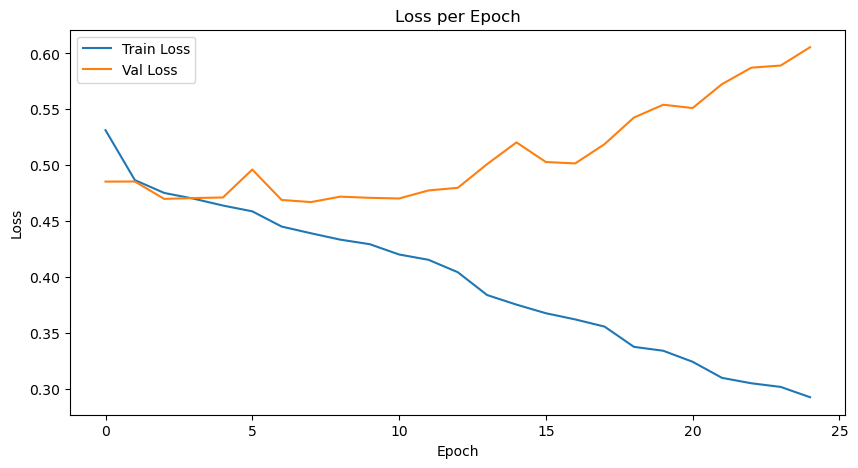

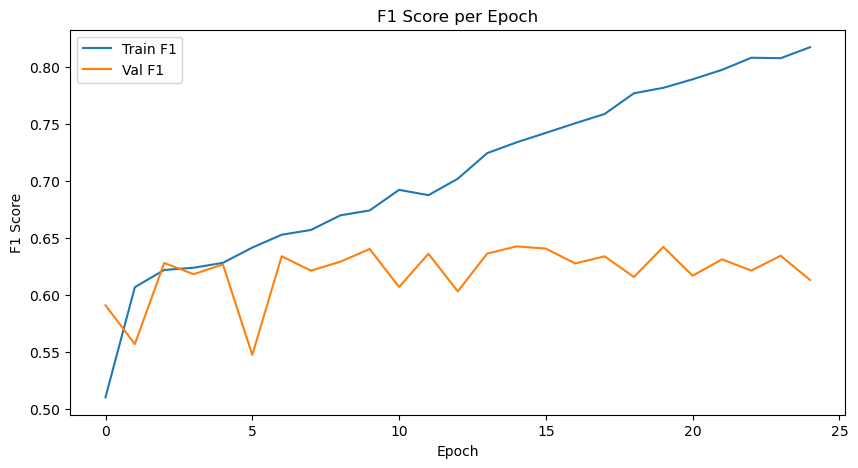

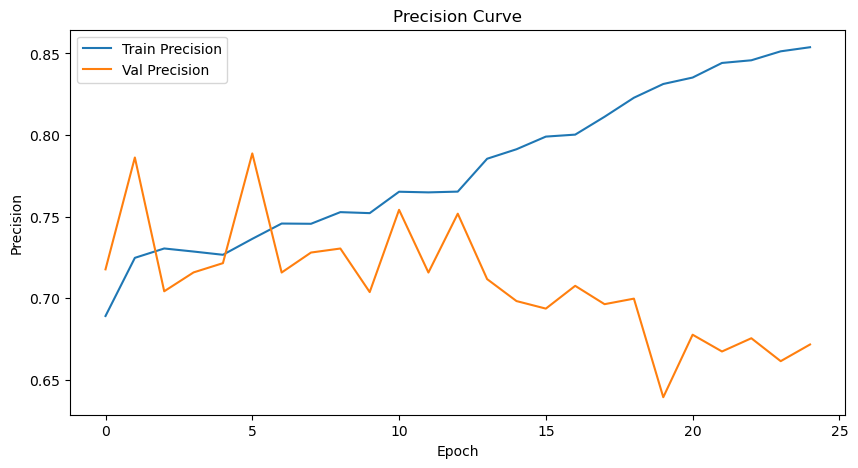

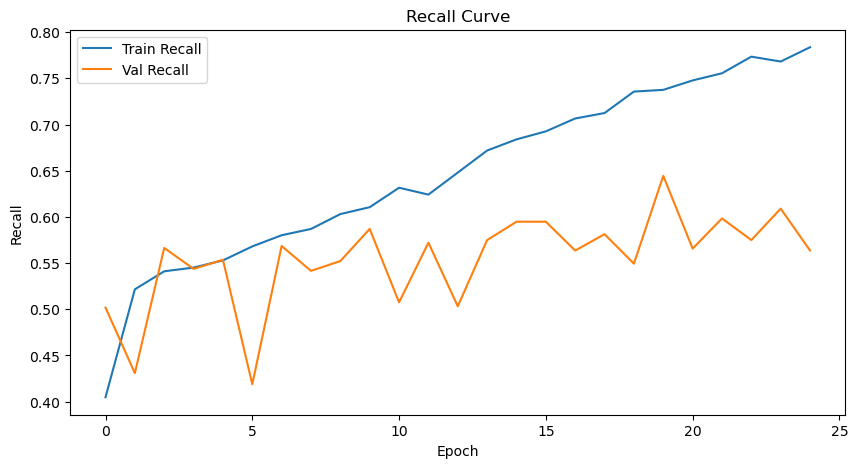

In [165]:
# Start measuring time
start_time = time.time()

# Split into train (70%) and validation (30%)
# Model, Loss, Optimizer
model1 = STLModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Early Stopping
best_val_f1 = 0
patience_counter = 0
early_stop_patience = 10  # or whatever you prefer

# Metrics recording
train_losses, val_losses = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

# Training Loop
# --- Initialize ---
num_epochs = 100
best_val_f1 = 0
history = {
    'train_loss': [],
    'val_loss': [],
    'train_precision': [],
    'val_precision': [],
    'train_recall': [],
    'val_recall': [],
    'train_f1': [],
    'val_f1': []
}


start_time = time.time()

for epoch in range(num_epochs):
    ######################
    # Training
    ######################
    model1.train()
    running_loss = 0
    preds_train = []
    labels_train = []
    
    for batch_x, batch_y in olid_train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).float()
        
        optimizer.zero_grad()
        outputs = model1(batch_x).squeeze()
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        preds_train += (outputs > 0.5).int().tolist()
        labels_train += batch_y.int().tolist()
    
    epoch_train_loss = running_loss / len(olid_train_loader)
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(labels_train, preds_train, average='binary', zero_division=0)

    ######################
    # Validation
    ######################
    model1.eval()
    running_val_loss = 0
    preds_val = []
    labels_val = []
    
    with torch.no_grad():
        for batch_x, batch_y in olid_val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).float()
            
            outputs = model1(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            
            running_val_loss += loss.item()
            
            preds_val += (outputs > 0.5).int().tolist()
            labels_val += batch_y.int().tolist()
    
    epoch_val_loss = running_val_loss / len(olid_val_loader)
    precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(labels_val, preds_val, average='binary', zero_division=0)

    ######################
    # Recording Metrics
    ######################
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_precision'].append(precision_train)
    history['val_precision'].append(precision_val)
    history['train_recall'].append(recall_train)
    history['val_recall'].append(recall_val)
    history['train_f1'].append(f1_train)
    history['val_f1'].append(f1_val)
    
    # Scheduler Step
    # --------------------
    scheduler.step(f1_val)
    
    ######################
    # Save Best Model
    ######################
    if f1_val > best_val_f1:
        best_val_f1 = f1_val
        patience_counter = 0  # reset counter if improvement
        torch.save(model1.state_dict(), "best_stl_model1.pth")
    else:
        patience_counter += 1
    
    ######################
    # Print Progress
    ######################
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | "
          f"Train F1: {f1_train:.4f}, Val F1: {f1_val:.4f} | "
          f"Train Precision: {precision_train:.4f}, Val Precision: {precision_val:.4f} | "
          f"Train Recall: {recall_train:.4f}, Val Recall: {recall_val:.4f} | "
         
         )
    
    if patience_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

######################
# Plotting
######################
plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10,5))
plt.plot(history['train_precision'], label='Train Precision')
plt.plot(history['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10,5))
plt.plot(history['train_recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.show()

## b. Multi Task Learning - Gated Double Encoder Model

Epoch 1/100
 [Abuse] Train L 0.488 P 0.694 R 0.605 F1 0.646  │ Val L 0.486 F1 0.650
 [Emo]   Train L 0.611 P 0.215 R 1.000 F1 0.336  │ Val L 0.597 F1 0.335
----------------------------------------------------------------------
Epoch 2/100
 [Abuse] Train L 0.473 P 0.721 R 0.608 F1 0.660  │ Val L 0.499 F1 0.639
 [Emo]   Train L 0.601 P 0.215 R 1.000 F1 0.336  │ Val L 0.598 F1 0.335
----------------------------------------------------------------------
Epoch 3/100
 [Abuse] Train L 0.476 P 0.706 R 0.606 F1 0.652  │ Val L 0.502 F1 0.661
 [Emo]   Train L 0.599 P 0.215 R 1.000 F1 0.336  │ Val L 0.597 F1 0.335
----------------------------------------------------------------------
Epoch 4/100
 [Abuse] Train L 0.476 P 0.713 R 0.597 F1 0.650  │ Val L 0.492 F1 0.666
 [Emo]   Train L 0.601 P 0.214 R 1.000 F1 0.336  │ Val L 0.600 F1 0.335
----------------------------------------------------------------------
Epoch 5/100
 [Abuse] Train L 0.469 P 0.705 R 0.611 F1 0.655  │ Val L 0.502 F1 0.671
 [Emo]  

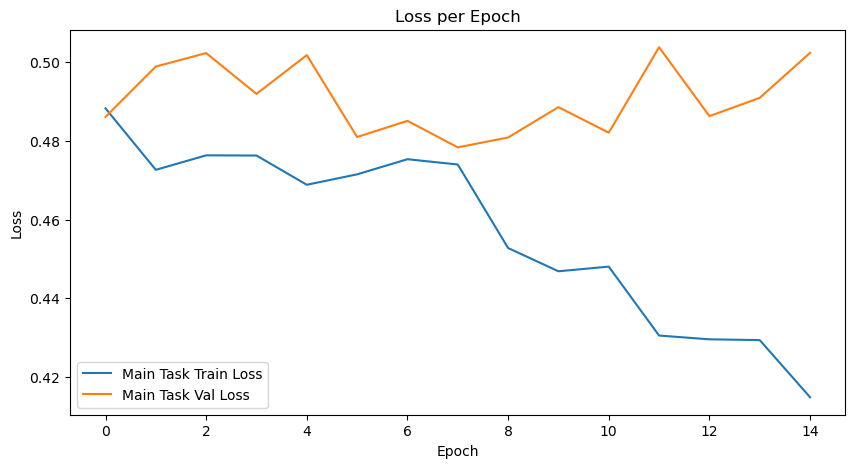

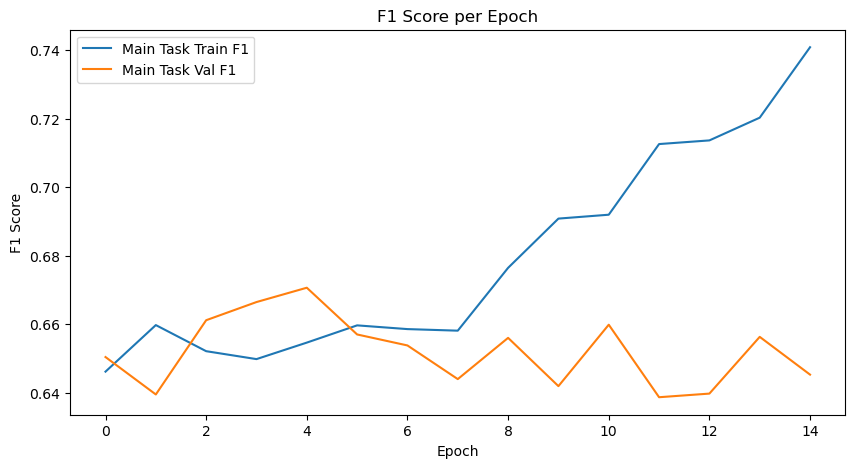

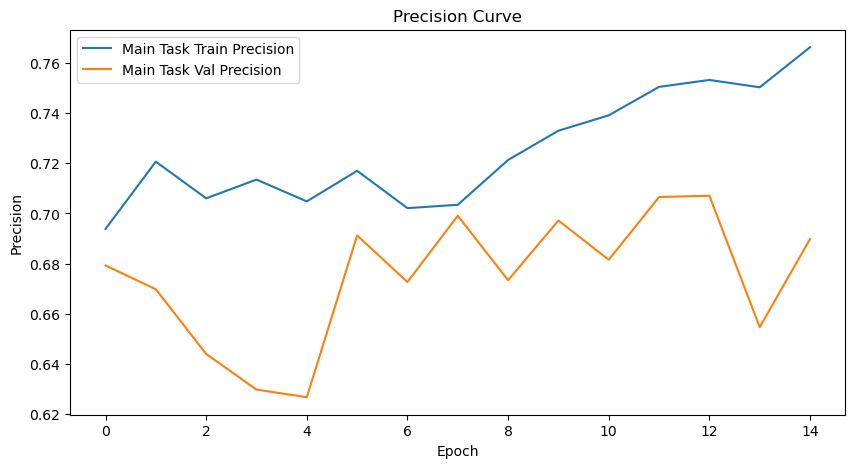

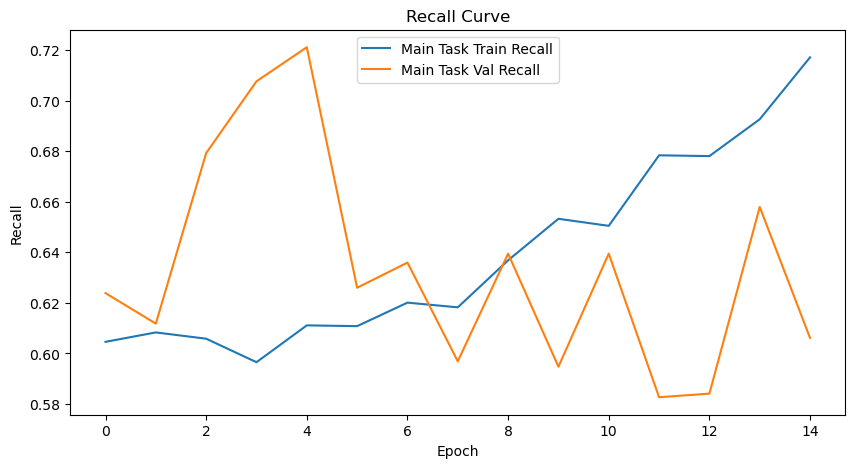

In [160]:
model2 = MTLGatedDEncoder().to(device)

criterion_abuse   = nn.BCEWithLogitsLoss()
criterion_emotion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=5e-3, weight_decay=5e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,patience=2, verbose=True)
beta = 0.1
early_stop_patience = 10

num_epochs = 100

# history dict
history2 = {
    'train_ab_loss': [], 'val_ab_loss': [],
    'train_ab_prec': [], 'val_ab_prec': [],
    'train_ab_rec':  [], 'val_ab_rec':  [],
    'train_ab_f1':   [], 'val_ab_f1':   [],
    'train_em_loss': [], 'val_em_loss': [],
    'train_em_prec': [], 'val_em_prec': [],
    'train_em_rec':  [], 'val_em_rec':  [],
    'train_em_f1':   [], 'val_em_f1':   []
}

best_ab_f1 = 0.0
patience_counter = 0
start_time = time.time()

for epoch in range(1, num_epochs+1):
    ####################
    # TRAINING
    ####################
    model2.train()
    ab_loss_sum, em_loss_sum = 0.0, 0.0

    # temp lists for metrics
    ab_preds, ab_trues = [], []
    em_preds_list, em_trues_list = [], []

    # cycle emotion loader if lengths differ
    emo_cycle = cycle(emotion_train_loader)
    for x_ab, y_ab in olid_train_loader:
        x_em, y_em = next(emo_cycle)

        x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
        x_em, y_em = x_em.to(device), y_em.to(device).float()

        optimizer.zero_grad()
        abuse_logits, emo_logits_ab = model2(x_ab)       # primary on abuse batch
        _,           emo_logits_em = model2(x_em)        # auxiliary on emo batch

        # compute losses
        loss_ab = criterion_abuse(abuse_logits, y_ab)
        loss_em = criterion_emotion(emo_logits_em, y_em)
        loss = (1 - beta) * loss_ab + beta * loss_em
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        optimizer.step()

        ab_loss_sum += loss_ab.item()
        em_loss_sum += loss_em.item()

        # record abuse preds
        ab_p = (torch.sigmoid(abuse_logits) > 0.5).int().cpu().tolist()
        ab_preds.extend(ab_p)
        ab_trues.extend(y_ab.int().cpu().tolist())

        # record emotion preds/trues as arrays
        em_p = (torch.sigmoid(emo_logits_em) > 0.35).int().cpu().numpy()  # (batch,11)
        em_preds_list.append(em_p)
        em_trues_list.append(y_em.cpu().numpy())

    # finalize training metrics
    avg_ab_train_loss = ab_loss_sum / len(olid_train_loader)
    ab_prec, ab_rec, ab_f1, _ = precision_recall_fscore_support(
        ab_trues, ab_preds, average='binary', zero_division=0
    )

    # stack emotion arrays and compute macro metrics
    em_preds = np.vstack(em_preds_list)
    em_trues = np.vstack(em_trues_list)
    avg_em_train_loss = em_loss_sum / len(olid_train_loader)
    em_prec, em_rec, em_f1, _ = precision_recall_fscore_support(
        em_trues, em_preds, average='macro', zero_division=0
    )

    history2['train_ab_loss'].append(avg_ab_train_loss)
    history2['train_ab_prec'].append(ab_prec)
    history2['train_ab_rec'].append(ab_rec)
    history2['train_ab_f1'].append(ab_f1)

    history2['train_em_loss'].append(avg_em_train_loss)
    history2['train_em_prec'].append(em_prec)
    history2['train_em_rec'].append(em_rec)
    history2['train_em_f1'].append(em_f1)


    ####################
    # VALIDATION
    ####################
    model2.eval()
    ab_vloss, em_vloss = 0.0, 0.0
    ab_vpreds, ab_vtrues = [], []
    em_vpreds_list, em_vtrues_list = [], []

    emo_cycle_val = cycle(emotion_val_loader)
    with torch.no_grad():
        for x_ab, y_ab in olid_val_loader:
            x_em, y_em = next(emo_cycle_val)

            x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
            x_em, y_em = x_em.to(device), y_em.to(device).float()

            abuse_logits, emo_logits_ab = model2(x_ab)
            _,            emo_logits_em = model2(x_em)

            lab = criterion_abuse(abuse_logits, y_ab)
            lem = criterion_emotion(emo_logits_em, y_em)

            ab_vloss += lab.item()
            em_vloss += lem.item()

            ab_vp = (torch.sigmoid(abuse_logits) > 0.5).int().cpu().tolist()
            ab_vpreds.extend(ab_vp)
            ab_vtrues.extend(y_ab.int().cpu().tolist())

            em_vp = (torch.sigmoid(emo_logits_em) > 0.35).int().cpu().numpy()
            em_vpreds_list.append(em_vp)
            em_vtrues_list.append(y_em.cpu().numpy())

    # finalize validation metrics
    avg_ab_val_loss = ab_vloss / len(olid_val_loader)
    ab_val_prec, ab_val_rec, ab_val_f1, _ = precision_recall_fscore_support(
        ab_vtrues, ab_vpreds, average='binary', zero_division=0
    )

    em_vpreds = np.vstack(em_vpreds_list)
    em_vtrues = np.vstack(em_vtrues_list)
    avg_em_val_loss = em_vloss / len(olid_val_loader)
    em_val_prec, em_val_rec, em_val_f1, _ = precision_recall_fscore_support(
        em_vtrues, em_vpreds, average='macro', zero_division=0
    )

    history2['val_ab_loss'].append(avg_ab_val_loss)
    history2['val_ab_prec'].append(ab_val_prec)
    history2['val_ab_rec'].append(ab_val_rec)
    history2['val_ab_f1'].append(ab_val_f1)

    history2['val_em_loss'].append(avg_em_val_loss)
    history2['val_em_prec'].append(em_val_prec)
    history2['val_em_rec'].append(em_val_rec)
    history2['val_em_f1'].append(em_val_f1)

    # Scheduler step on primary task F1
    scheduler.step(ab_val_f1)

    # Early stopping on primary task F1
    if ab_val_f1 > best_ab_f1 + 1e-4:
        best_ab_f1 = ab_val_f1
        patience_counter = 0
        torch.save(model2.state_dict(), 'best_mtl_model2.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping on epoch {epoch}")
            break

    # print progress
    print(f"Epoch {epoch}/{num_epochs}")
    print(f" [Abuse] Train L {avg_ab_train_loss:.3f} P {ab_prec:.3f} R {ab_rec:.3f} F1 {ab_f1:.3f}  │ Val L {avg_ab_val_loss:.3f} F1 {ab_val_f1:.3f}")
    print(f" [Emo]   Train L {avg_em_train_loss:.3f} P {em_prec:.3f} R {em_rec:.3f} F1 {em_f1:.3f}  │ Val L {avg_em_val_loss:.3f} F1 {em_val_f1:.3f}")
    print("-"*70)

total_time = time.time() - start_time
print(f"Total training time: {total_time/60:.2f} minutes")


######################
# Plotting
######################
plt.figure(figsize=(10,5))
plt.plot(history2['train_ab_loss'], label='Main Task Train Loss')
plt.plot(history2['val_ab_loss'], label='Main Task Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history2['train_ab_f1'], label='Main Task Train F1')
plt.plot(history2['val_ab_f1'], label='Main Task Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10,5))
plt.plot(history2['train_ab_prec'], label='Main Task Train Precision')
plt.plot(history2['val_ab_prec'], label='Main Task Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10,5))
plt.plot(history2['train_ab_rec'], label='Main Task Train Recall')
plt.plot(history2['val_ab_rec'], label='Main Task Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.show()


## c. Multi Task Learning - Gated Double Encoder Model V2 (Two Auxiliary Tasks)

###### model3 = MTLGatedDEncoderV2().to(device)

criterion_abuse   = nn.BCEWithLogitsLoss()
criterion_emotion = nn.BCEWithLogitsLoss()
criterion_irony   = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model3.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

beta_emotion = 0.1
beta_irony   = 0.1
early_stop_patience = 10
num_epochs = 50

# ── History dict ──
history3 = {
    'train_ab_loss': [], 'val_ab_loss': [],
    'train_ab_prec': [], 'val_ab_prec': [],
    'train_ab_rec':  [], 'val_ab_rec':  [],
    'train_ab_f1':   [], 'val_ab_f1':   [],

    'train_em_loss': [], 'val_em_loss': [],
    'train_em_prec': [], 'val_em_prec': [],
    'train_em_rec':  [], 'val_em_rec':  [],
    'train_em_f1':   [], 'val_em_f1':   [],

    'train_ir_loss': [], 'val_ir_loss': [],
    'train_ir_prec': [], 'val_ir_prec': [],
    'train_ir_rec':  [], 'val_ir_rec':  [],
    'train_ir_f1':   [], 'val_ir_f1':   [],
}

best_val_f1 = 0
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    ############################
    # TRAINING
    ############################
    model3.train()
    ab_losses, em_losses, ir_losses = [], [], []
    ab_preds, ab_trues = [], []
    em_preds, em_trues = [], []
    ir_preds, ir_trues = [], []

    emo_cycle = cycle(emotion_train_loader)
    irony_cycle = cycle(iro_train_loader)

    for x_ab, y_ab in olid_train_loader:
        x_em, y_em = next(emo_cycle)
        x_ir, y_ir = next(irony_cycle)

        x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
        x_em, y_em = x_em.to(device), y_em.to(device).float()
        x_ir, y_ir = x_ir.to(device), y_ir.to(device).float()

        optimizer.zero_grad()

        abuse_logits, _, _ = model3(x_ab)       # abuse batch
        _, emotion_logits, _ = model3(x_em)     # emotion batch
        _, _, irony_logits = model3(x_ir)       # irony batch

        loss_ab = criterion_abuse(abuse_logits, y_ab)
        loss_em = criterion_emotion(emotion_logits, y_em)
        loss_ir = criterion_irony(irony_logits, y_ir)

        loss = (1 - beta_emotion - beta_irony) * loss_ab + beta_emotion * loss_em + beta_irony * loss_ir
        loss.backward()
        nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1.0)
        optimizer.step()

        ab_losses.append(loss_ab.item())
        em_losses.append(loss_em.item())
        ir_losses.append(loss_ir.item())

        # abuse preds
        preds = (torch.sigmoid(abuse_logits) > 0.5).long().cpu().numpy()
        labels = y_ab.long().cpu().numpy()
        ab_preds.extend(preds)
        ab_trues.extend(labels)

        # emotion preds
        preds = (torch.sigmoid(emotion_logits) > 0.5).long().cpu().numpy()
        labels = y_em.long().cpu().numpy()
        em_preds.append(preds)
        em_trues.append(labels)

        # irony preds
        preds = (torch.sigmoid(irony_logits) > 0.5).long().cpu().numpy()
        labels = y_ir.long().cpu().numpy()
        ir_preds.extend(preds)
        ir_trues.extend(labels)

    # compute train metrics
    ab_prec, ab_rec, ab_f1, _ = precision_recall_fscore_support(
        ab_trues, ab_preds, average='binary', zero_division=0
    )
    em_preds = np.vstack(em_preds)
    em_trues = np.vstack(em_trues)
    em_prec, em_rec, em_f1, _ = precision_recall_fscore_support(
        em_trues, em_preds, average='macro', zero_division=0
    )
    ir_prec, ir_rec, ir_f1, _ = precision_recall_fscore_support(
        ir_trues, ir_preds, average='binary', zero_division=0
    )

    history3['train_ab_loss'].append(np.mean(ab_losses))
    history3['train_ab_prec'].append(ab_prec)
    history3['train_ab_rec'].append(ab_rec)
    history3['train_ab_f1'].append(ab_f1)

    history3['train_em_loss'].append(np.mean(em_losses))
    history3['train_em_prec'].append(em_prec)
    history3['train_em_rec'].append(em_rec)
    history3['train_em_f1'].append(em_f1)

    history3['train_ir_loss'].append(np.mean(ir_losses))
    history3['train_ir_prec'].append(ir_prec)
    history3['train_ir_rec'].append(ir_rec)
    history3['train_ir_f1'].append(ir_f1)

    ############################
    # VALIDATION
    ############################
    model3.eval()
    ab_losses, em_losses, ir_losses = [], [], []
    ab_preds, ab_trues = [], []
    em_preds, em_trues = [], []
    ir_preds, ir_trues = [], []

    emo_cycle = cycle(emotion_val_loader)
    irony_cycle = cycle(iro_val_loader)

    with torch.no_grad():
        for x_ab, y_ab in olid_val_loader:
            x_em, y_em = next(emo_cycle)
            x_ir, y_ir = next(irony_cycle)

            x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
            x_em, y_em = x_em.to(device), y_em.to(device).float()
            x_ir, y_ir = x_ir.to(device), y_ir.to(device).float()

            abuse_logits, _, _ = model3(x_ab)
            _, emotion_logits, _ = model3(x_em)
            _, _, irony_logits = model3(x_ir)

            lab = criterion_abuse(abuse_logits, y_ab)
            lem = criterion_emotion(emotion_logits, y_em)
            lir = criterion_irony(irony_logits, y_ir)

            ab_losses.append(lab.item())
            em_losses.append(lem.item())
            ir_losses.append(lir.item())

            preds = (torch.sigmoid(abuse_logits) > 0.5).long().cpu().numpy()
            labels = y_ab.long().cpu().numpy()
            ab_preds.extend(preds)
            ab_trues.extend(labels)

            preds = (torch.sigmoid(emotion_logits) > 0.5).long().cpu().numpy()
            labels = y_em.long().cpu().numpy()
            em_preds.append(preds)
            em_trues.append(labels)

            preds = (torch.sigmoid(irony_logits) > 0.5).long().cpu().numpy()
            labels = y_ir.long().cpu().numpy()
            ir_preds.extend(preds)
            ir_trues.extend(labels)

    # compute val metrics
    ab_prec, ab_rec, ab_f1, _ = precision_recall_fscore_support(
        ab_trues, ab_preds, average='binary', zero_division=0
    )
    em_preds = np.vstack(em_preds)
    em_trues = np.vstack(em_trues)
    em_prec, em_rec, em_f1, _ = precision_recall_fscore_support(
        em_trues, em_preds, average='macro', zero_division=0
    )
    ir_prec, ir_rec, ir_f1, _ = precision_recall_fscore_support(
        ir_trues, ir_preds, average='binary', zero_division=0
    )

    history3['val_ab_loss'].append(np.mean(ab_losses))
    history3['val_ab_prec'].append(ab_prec)
    history3['val_ab_rec'].append(ab_rec)
    history3['val_ab_f1'].append(ab_f1)

    history3['val_em_loss'].append(np.mean(em_losses))
    history3['val_em_prec'].append(em_prec)
    history3['val_em_rec'].append(em_rec)
    history3['val_em_f1'].append(em_f1)

    history3['val_ir_loss'].append(np.mean(ir_losses))
    history3['val_ir_prec'].append(ir_prec)
    history3['val_ir_rec'].append(ir_rec)
    history3['val_ir_f1'].append(ir_f1)

    scheduler.step(ab_f1)

    print(f"Epoch {epoch}: [Abuse] Train F1={history3['train_ab_f1'][-1]:.4f} │ Val F1={history3['val_ab_f1'][-1]:.4f} │ [Emotion] Val F1={history3['val_em_f1'][-1]:.4f} │ [Irony] Val F1={history3['val_ir_f1'][-1]:.4f}")

    if ab_f1 > best_val_f1:
        best_val_f1 = ab_f1
        patience_counter = 0
        torch.save(model3.state_dict(), 'best_mtl_model_3.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}")
            break


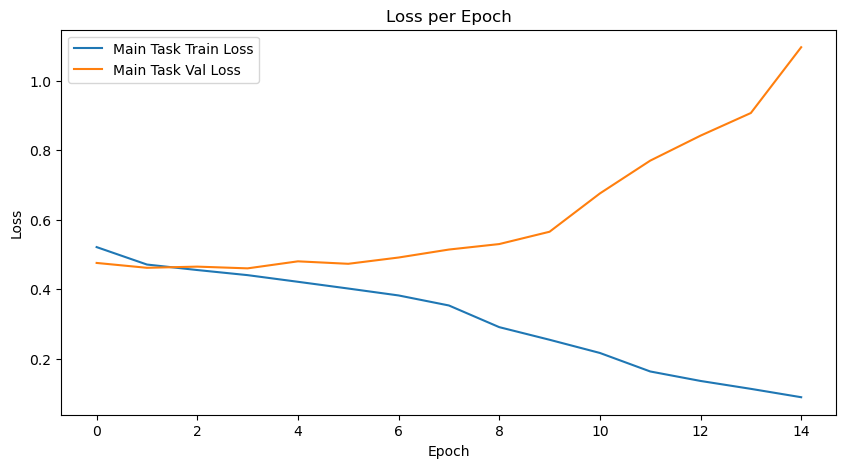

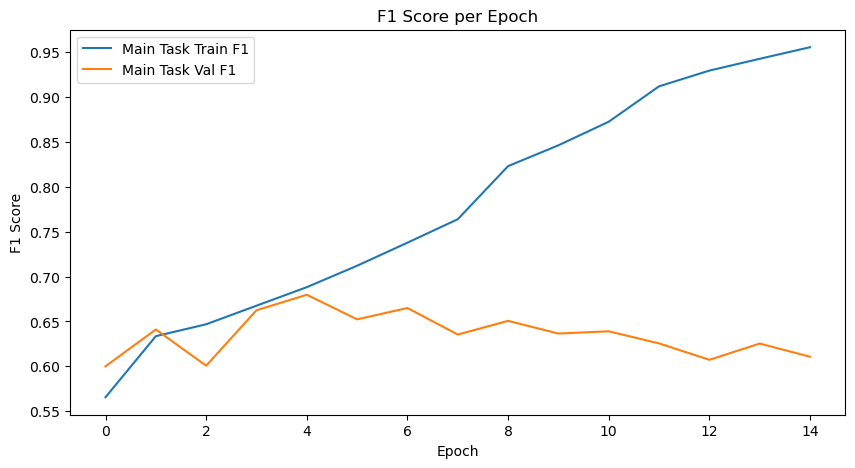

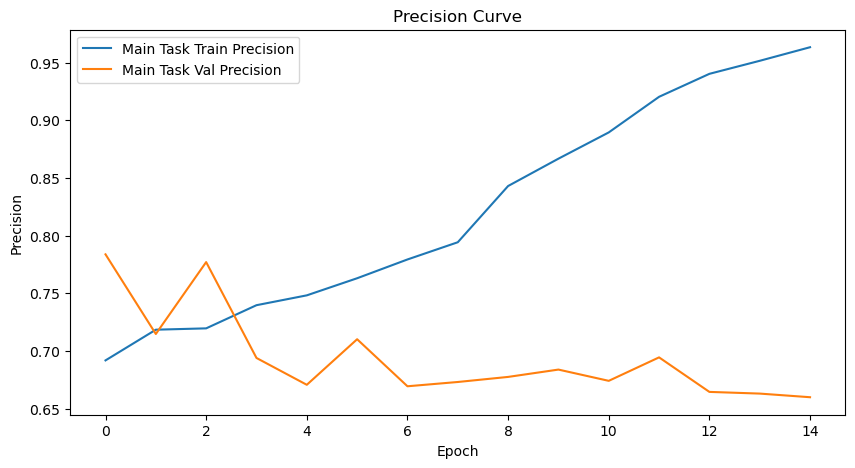

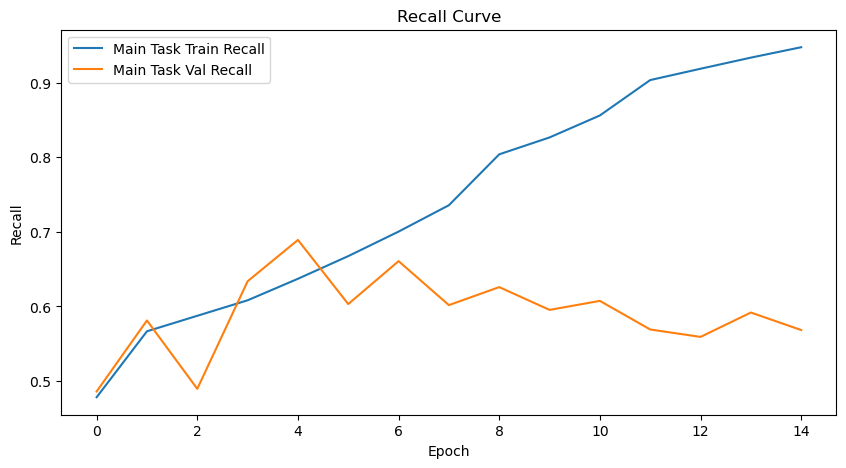

In [273]:
######################
# Plotting
######################
plt.figure(figsize=(10,5))
plt.plot(history3['train_ab_loss'], label='Main Task Train Loss')
plt.plot(history3['val_ab_loss'], label='Main Task Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history3['train_ab_f1'], label='Main Task Train F1')
plt.plot(history3['val_ab_f1'], label='Main Task Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10,5))
plt.plot(history3['train_ab_prec'], label='Main Task Train Precision')
plt.plot(history3['val_ab_prec'], label='Main Task Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10,5))
plt.plot(history3['train_ab_rec'], label='Main Task Train Recall')
plt.plot(history3['val_ab_rec'], label='Main Task Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.show()

## Dealing with HateXplainDataset

### a. Single Task Learning

Epoch 1/100 | Train Loss: 0.6927, Val Loss: 0.6956 | Train F1: 0.6125, Val F1: 0.6582 | Train Precision: 0.5200, Val Precision: 0.4906 | Train Recall: 0.7449, Val Recall: 1.0000 | 
Epoch 2/100 | Train Loss: 0.6929, Val Loss: 0.6942 | Train F1: 0.6801, Val F1: 0.6582 | Train Precision: 0.5152, Val Precision: 0.4906 | Train Recall: 1.0000, Val Recall: 1.0000 | 
Epoch 3/100 | Train Loss: 0.6927, Val Loss: 0.6939 | Train F1: 0.6801, Val F1: 0.6582 | Train Precision: 0.5152, Val Precision: 0.4906 | Train Recall: 1.0000, Val Recall: 1.0000 | 
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch 4/100 | Train Loss: 0.6928, Val Loss: 0.6939 | Train F1: 0.6801, Val F1: 0.6582 | Train Precision: 0.5152, Val Precision: 0.4906 | Train Recall: 1.0000, Val Recall: 1.0000 | 
Epoch 5/100 | Train Loss: 0.6927, Val Loss: 0.6940 | Train F1: 0.6801, Val F1: 0.6582 | Train Precision: 0.5152, Val Precision: 0.4906 | Train Recall: 1.0000, Val Recall: 1.0000 | 
Epoch 6/100 | Train Loss: 0.6927,

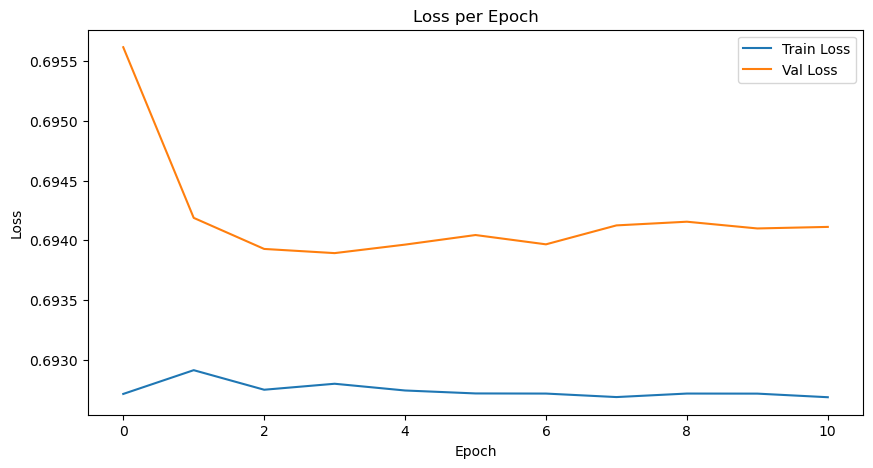

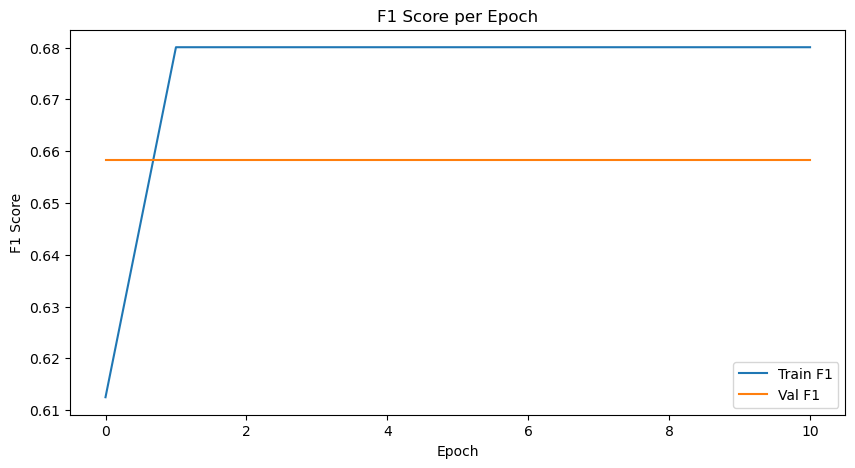

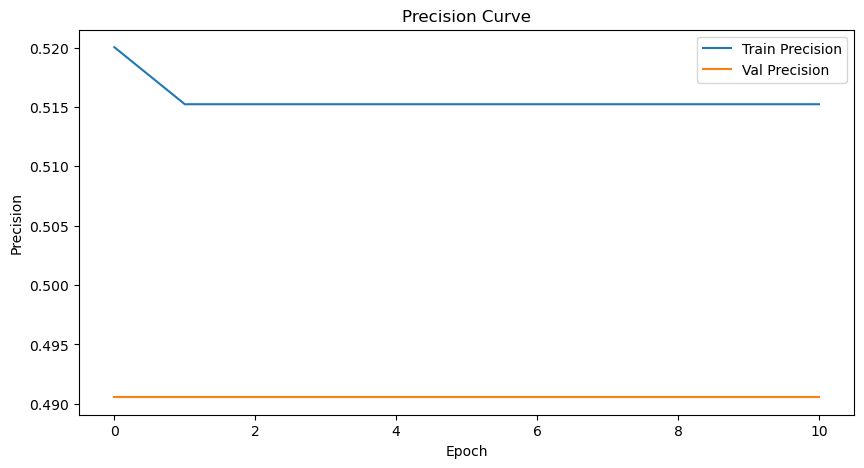

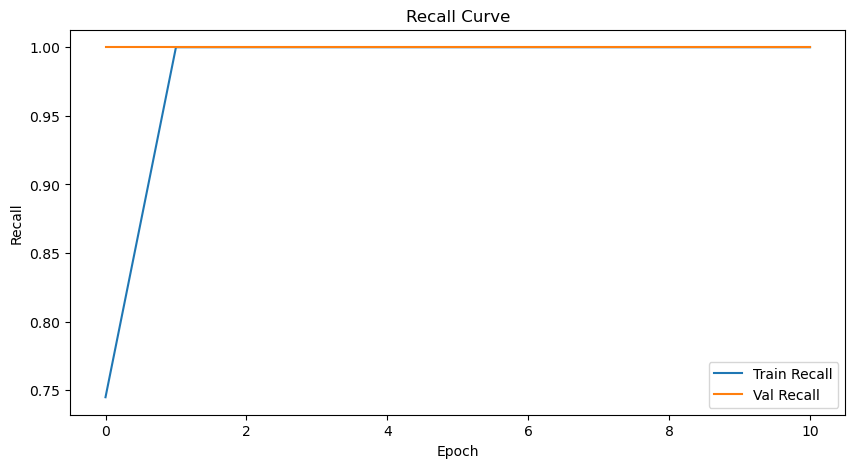

In [392]:
# Start measuring time
start_time = time.time()

# Split into train (70%) and validation (30%)
# Model, Loss, Optimizer
model1a = STLModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1a.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Early Stopping
best_val_f1 = 0
patience_counter = 0
early_stop_patience = 10  # or whatever you prefer

# Metrics recording
train_losses, val_losses = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

# Training Loop
# --- Initialize ---
num_epochs = 100
best_val_f1 = 0
history1a = {
    'train_loss': [],
    'val_loss': [],
    'train_precision': [],
    'val_precision': [],
    'train_recall': [],
    'val_recall': [],
    'train_f1': [],
    'val_f1': []
}


start_time = time.time()

for epoch in range(num_epochs):
    ######################
    # Training
    ######################
    model1a.train()
    running_loss = 0
    preds_train = []
    labels_train = []
    
    for batch_x, batch_y in hate_train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).float()
        
        optimizer.zero_grad()
        outputs = model1a(batch_x).squeeze()
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        preds_train += (outputs > 0.5).int().tolist()
        labels_train += batch_y.int().tolist()
    
    epoch_train_loss = running_loss / len(hate_train_loader)
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(labels_train, preds_train, average='binary', zero_division=0)

    ######################
    # Validation
    ######################
    model1a.eval()
    running_val_loss = 0
    preds_val = []
    labels_val = []
    
    with torch.no_grad():
        for batch_x, batch_y in hate_val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).float()
            
            outputs = model1a(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            
            running_val_loss += loss.item()
            
            preds_val += (outputs > 0.5).int().tolist()
            labels_val += batch_y.int().tolist()
    
    epoch_val_loss = running_val_loss / len(hate_val_loader)
    precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(labels_val, preds_val, average='binary', zero_division=0)

    ######################
    # Recording Metrics
    ######################
    history1a['train_loss'].append(epoch_train_loss)
    history1a['val_loss'].append(epoch_val_loss)
    history1a['train_precision'].append(precision_train)
    history1a['val_precision'].append(precision_val)
    history1a['train_recall'].append(recall_train)
    history1a['val_recall'].append(recall_val)
    history1a['train_f1'].append(f1_train)
    history1a['val_f1'].append(f1_val)
    
    # Scheduler Step
    # --------------------
    scheduler.step(f1_val)
    
    ######################
    # Save Best Model
    ######################
    if f1_val > best_val_f1:
        best_val_f1 = f1_val
        patience_counter = 0  # reset counter if improvement
        torch.save(model1a.state_dict(), "best_stl_model1a.pth")
    else:
        patience_counter += 1
    
    ######################
    # Print Progress
    ######################
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | "
          f"Train F1: {f1_train:.4f}, Val F1: {f1_val:.4f} | "
          f"Train Precision: {precision_train:.4f}, Val Precision: {precision_val:.4f} | "
          f"Train Recall: {recall_train:.4f}, Val Recall: {recall_val:.4f} | "
         
         )
    
    if patience_counter >= early_stop_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

######################
# Plotting
######################
plt.figure(figsize=(10,5))
plt.plot(history1a['train_loss'], label='Train Loss')
plt.plot(history1a['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history1a['train_f1'], label='Train F1')
plt.plot(history1a['val_f1'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10,5))
plt.plot(history1a['train_precision'], label='Train Precision')
plt.plot(history1a['val_precision'], label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10,5))
plt.plot(history1a['train_recall'], label='Train Recall')
plt.plot(history1a['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.show()

Epoch 1/100
 [Abuse] Train L 0.694 P 0.514 R 0.744 F1 0.608  │ Val L 0.694 F1 0.658
 [Emo]   Train L 0.586 P 0.214 R 0.929 F1 0.334  │ Val L 0.591 F1 0.337
----------------------------------------------------------------------
Epoch 2/100
 [Abuse] Train L 0.693 P 0.517 R 0.933 F1 0.665  │ Val L 0.693 F1 0.658
 [Emo]   Train L 0.590 P 0.214 R 1.000 F1 0.335  │ Val L 0.590 F1 0.337
----------------------------------------------------------------------
Epoch 3/100
 [Abuse] Train L 0.694 P 0.515 R 0.817 F1 0.632  │ Val L 0.694 F1 0.658
 [Emo]   Train L 0.590 P 0.214 R 1.000 F1 0.335  │ Val L 0.591 F1 0.337
----------------------------------------------------------------------
Epoch 00004: reducing learning rate of group 0 to 5.0000e-03.
Epoch 4/100
 [Abuse] Train L 0.693 P 0.513 R 0.911 F1 0.657  │ Val L 0.693 F1 0.658
 [Emo]   Train L 0.590 P 0.214 R 1.000 F1 0.335  │ Val L 0.590 F1 0.337
----------------------------------------------------------------------
Epoch 5/100
 [Abuse] Train L 0

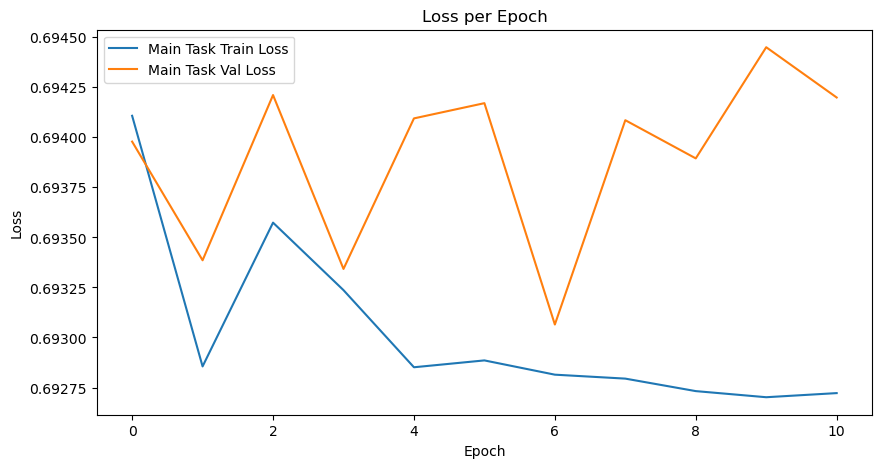

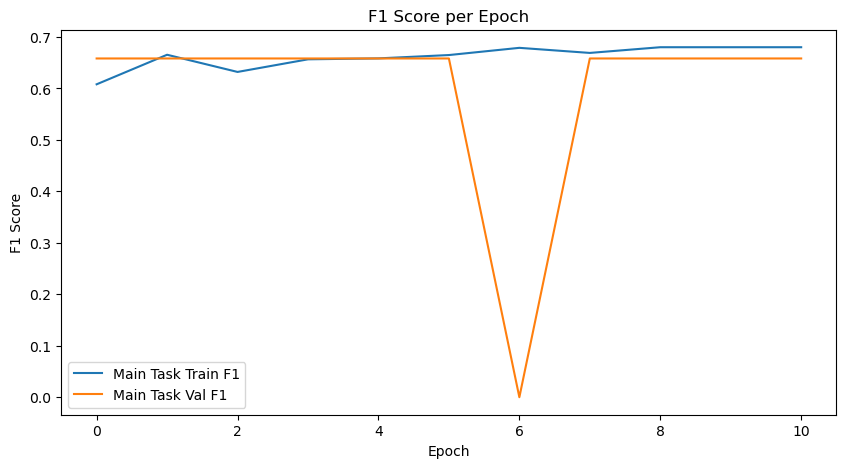

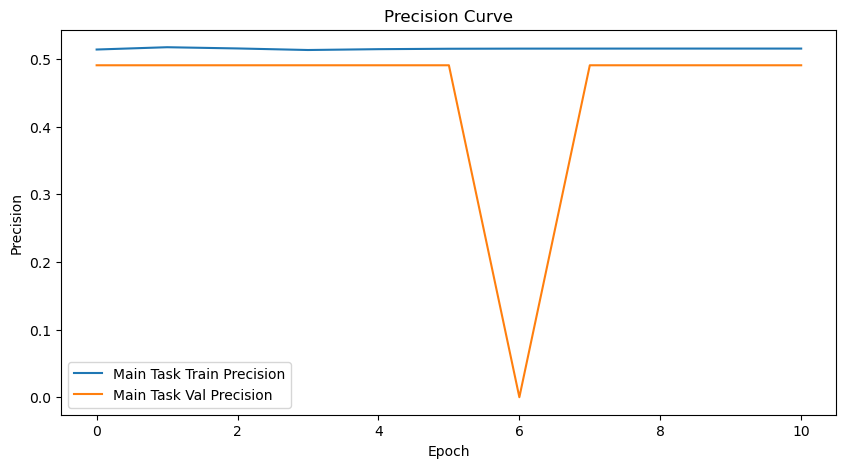

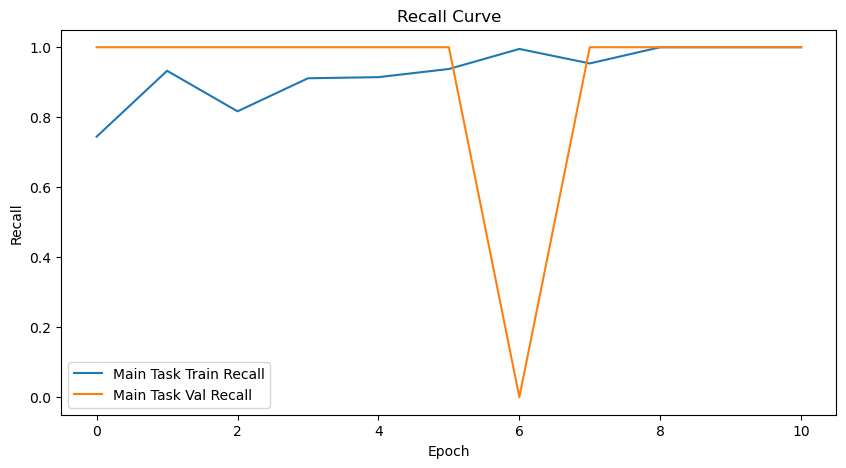

In [403]:
model2a = MTLGatedDEncoder().to(device)

criterion_abuse   = nn.BCEWithLogitsLoss()
criterion_emotion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2a.parameters(), lr=1e-2, weight_decay=5e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,patience=2, verbose=True)
beta = 0.1
early_stop_patience = 10

num_epochs = 100

# history dict
history2a = {
    'train_ab_loss': [], 'val_ab_loss': [],
    'train_ab_prec': [], 'val_ab_prec': [],
    'train_ab_rec':  [], 'val_ab_rec':  [],
    'train_ab_f1':   [], 'val_ab_f1':   [],
    'train_em_loss': [], 'val_em_loss': [],
    'train_em_prec': [], 'val_em_prec': [],
    'train_em_rec':  [], 'val_em_rec':  [],
    'train_em_f1':   [], 'val_em_f1':   []
}

best_ab_f1 = 0.0
patience_counter = 0
start_time = time.time()

for epoch in range(1, num_epochs+1):
    ####################
    # TRAINING
    ####################
    model2a.train()
    ab_loss_sum, em_loss_sum = 0.0, 0.0

    # temp lists for metrics
    ab_preds, ab_trues = [], []
    em_preds_list, em_trues_list = [], []

    # cycle emotion loader if lengths differ
    emo_cycle = cycle(emotion_train_loader)
    for x_ab, y_ab in hate_train_loader:
        x_em, y_em = next(emo_cycle)

        x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
        x_em, y_em = x_em.to(device), y_em.to(device).float()

        optimizer.zero_grad()
        abuse_logits, emo_logits_ab = model2a(x_ab)       # primary on abuse batch
        _,           emo_logits_em = model2a(x_em)        # auxiliary on emo batch

        # compute losses
        loss_ab = criterion_abuse(abuse_logits, y_ab)
        loss_em = criterion_emotion(emo_logits_em, y_em)
        loss = (1 - beta) * loss_ab + beta * loss_em
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2a.parameters(), max_norm=1.0)
        optimizer.step()

        ab_loss_sum += loss_ab.item()
        em_loss_sum += loss_em.item()

        # record abuse preds
        ab_p = (torch.sigmoid(abuse_logits) > 0.5).int().cpu().tolist()
        ab_preds.extend(ab_p)
        ab_trues.extend(y_ab.int().cpu().tolist())

        # record emotion preds/trues as arrays
        em_p = (torch.sigmoid(emo_logits_em) > 0.35).int().cpu().numpy()  # (batch,11)
        em_preds_list.append(em_p)
        em_trues_list.append(y_em.cpu().numpy())

    # finalize training metrics
    avg_ab_train_loss = ab_loss_sum / len(hate_train_loader)
    ab_prec, ab_rec, ab_f1, _ = precision_recall_fscore_support(
        ab_trues, ab_preds, average='binary', zero_division=0
    )

    # stack emotion arrays and compute macro metrics
    em_preds = np.vstack(em_preds_list)
    em_trues = np.vstack(em_trues_list)
    avg_em_train_loss = em_loss_sum / len(hate_train_loader)
    em_prec, em_rec, em_f1, _ = precision_recall_fscore_support(
        em_trues, em_preds, average='macro', zero_division=0
    )

    history2a['train_ab_loss'].append(avg_ab_train_loss)
    history2a['train_ab_prec'].append(ab_prec)
    history2a['train_ab_rec'].append(ab_rec)
    history2a['train_ab_f1'].append(ab_f1)

    history2a['train_em_loss'].append(avg_em_train_loss)
    history2a['train_em_prec'].append(em_prec)
    history2a['train_em_rec'].append(em_rec)
    history2a['train_em_f1'].append(em_f1)


    ####################
    # VALIDATION
    ####################
    model2a.eval()
    ab_vloss, em_vloss = 0.0, 0.0
    ab_vpreds, ab_vtrues = [], []
    em_vpreds_list, em_vtrues_list = [], []

    emo_cycle_val = cycle(emotion_val_loader)
    with torch.no_grad():
        for x_ab, y_ab in hate_val_loader:
            x_em, y_em = next(emo_cycle_val)

            x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
            x_em, y_em = x_em.to(device), y_em.to(device).float()

            abuse_logits, emo_logits_ab = model2a(x_ab)
            _,            emo_logits_em = model2a(x_em)

            lab = criterion_abuse(abuse_logits, y_ab)
            lem = criterion_emotion(emo_logits_em, y_em)

            ab_vloss += lab.item()
            em_vloss += lem.item()

            ab_vp = (torch.sigmoid(abuse_logits) > 0.5).int().cpu().tolist()
            ab_vpreds.extend(ab_vp)
            ab_vtrues.extend(y_ab.int().cpu().tolist())

            em_vp = (torch.sigmoid(emo_logits_em) > 0.35).int().cpu().numpy()
            em_vpreds_list.append(em_vp)
            em_vtrues_list.append(y_em.cpu().numpy())

    # finalize validation metrics
    avg_ab_val_loss = ab_vloss / len(hate_val_loader)
    ab_val_prec, ab_val_rec, ab_val_f1, _ = precision_recall_fscore_support(
        ab_vtrues, ab_vpreds, average='binary', zero_division=0
    )

    em_vpreds = np.vstack(em_vpreds_list)
    em_vtrues = np.vstack(em_vtrues_list)
    avg_em_val_loss = em_vloss / len(hate_val_loader)
    em_val_prec, em_val_rec, em_val_f1, _ = precision_recall_fscore_support(
        em_vtrues, em_vpreds, average='macro', zero_division=0
    )

    history2a['val_ab_loss'].append(avg_ab_val_loss)
    history2a['val_ab_prec'].append(ab_val_prec)
    history2a['val_ab_rec'].append(ab_val_rec)
    history2a['val_ab_f1'].append(ab_val_f1)

    history2a['val_em_loss'].append(avg_em_val_loss)
    history2a['val_em_prec'].append(em_val_prec)
    history2a['val_em_rec'].append(em_val_rec)
    history2a['val_em_f1'].append(em_val_f1)

    # Scheduler step on primary task F1
    scheduler.step(ab_val_f1)

    # Early stopping on primary task F1
    if ab_val_f1 > best_ab_f1 + 1e-4:
        best_ab_f1 = ab_val_f1
        patience_counter = 0
        torch.save(model2a.state_dict(), 'best_mtl_model2a.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping on epoch {epoch}")
            break

    # print progress
    print(f"Epoch {epoch}/{num_epochs}")
    print(f" [Abuse] Train L {avg_ab_train_loss:.3f} P {ab_prec:.3f} R {ab_rec:.3f} F1 {ab_f1:.3f}  │ Val L {avg_ab_val_loss:.3f} F1 {ab_val_f1:.3f}")
    print(f" [Emo]   Train L {avg_em_train_loss:.3f} P {em_prec:.3f} R {em_rec:.3f} F1 {em_f1:.3f}  │ Val L {avg_em_val_loss:.3f} F1 {em_val_f1:.3f}")
    print("-"*70)

total_time = time.time() - start_time
print(f"Total training time: {total_time/60:.2f} minutes")


######################
# Plotting
######################
plt.figure(figsize=(10,5))
plt.plot(history2a['train_ab_loss'], label='Main Task Train Loss')
plt.plot(history2a['val_ab_loss'], label='Main Task Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history2a['train_ab_f1'], label='Main Task Train F1')
plt.plot(history2a['val_ab_f1'], label='Main Task Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10,5))
plt.plot(history2a['train_ab_prec'], label='Main Task Train Precision')
plt.plot(history2a['val_ab_prec'], label='Main Task Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10,5))
plt.plot(history2a['train_ab_rec'], label='Main Task Train Recall')
plt.plot(history2a['val_ab_rec'], label='Main Task Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.show()


In [395]:
model3a = MTLGatedDEncoderV2().to(device)

criterion_abuse   = nn.BCEWithLogitsLoss()
criterion_emotion = nn.BCEWithLogitsLoss()
criterion_irony   = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model3a.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

beta_emotion = 0.1
beta_irony   = 0.1
early_stop_patience = 10
num_epochs = 50

# ── History dict ──
history3a = {
    'train_ab_loss': [], 'val_ab_loss': [],
    'train_ab_prec': [], 'val_ab_prec': [],
    'train_ab_rec':  [], 'val_ab_rec':  [],
    'train_ab_f1':   [], 'val_ab_f1':   [],

    'train_em_loss': [], 'val_em_loss': [],
    'train_em_prec': [], 'val_em_prec': [],
    'train_em_rec':  [], 'val_em_rec':  [],
    'train_em_f1':   [], 'val_em_f1':   [],

    'train_ir_loss': [], 'val_ir_loss': [],
    'train_ir_prec': [], 'val_ir_prec': [],
    'train_ir_rec':  [], 'val_ir_rec':  [],
    'train_ir_f1':   [], 'val_ir_f1':   [],
}

best_val_f1 = 0
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    ############################
    # TRAINING
    ############################
    model3a.train()
    ab_losses, em_losses, ir_losses = [], [], []
    ab_preds, ab_trues = [], []
    em_preds, em_trues = [], []
    ir_preds, ir_trues = [], []

    emo_cycle = cycle(emotion_train_loader)
    irony_cycle = cycle(iro_train_loader)

    for x_ab, y_ab in hate_train_loader:
        x_em, y_em = next(emo_cycle)
        x_ir, y_ir = next(irony_cycle)

        x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
        x_em, y_em = x_em.to(device), y_em.to(device).float()
        x_ir, y_ir = x_ir.to(device), y_ir.to(device).float()

        optimizer.zero_grad()

        abuse_logits, _, _ = model3a(x_ab)       # abuse batch
        _, emotion_logits, _ = model3a(x_em)     # emotion batch
        _, _, irony_logits = model3a(x_ir)       # irony batch

        loss_ab = criterion_abuse(abuse_logits, y_ab)
        loss_em = criterion_emotion(emotion_logits, y_em)
        loss_ir = criterion_irony(irony_logits, y_ir)

        loss = (1 - beta_emotion - beta_irony) * loss_ab + beta_emotion * loss_em + beta_irony * loss_ir
        loss.backward()
        nn.utils.clip_grad_norm_(model3a.parameters(), max_norm=1.0)
        optimizer.step()

        ab_losses.append(loss_ab.item())
        em_losses.append(loss_em.item())
        ir_losses.append(loss_ir.item())

        # abuse preds
        preds = (torch.sigmoid(abuse_logits) > 0.5).long().cpu().numpy()
        labels = y_ab.long().cpu().numpy()
        ab_preds.extend(preds)
        ab_trues.extend(labels)

        # emotion preds
        preds = (torch.sigmoid(emotion_logits) > 0.5).long().cpu().numpy()
        labels = y_em.long().cpu().numpy()
        em_preds.append(preds)
        em_trues.append(labels)

        # irony preds
        preds = (torch.sigmoid(irony_logits) > 0.5).long().cpu().numpy()
        labels = y_ir.long().cpu().numpy()
        ir_preds.extend(preds)
        ir_trues.extend(labels)

    # compute train metrics
    ab_prec, ab_rec, ab_f1, _ = precision_recall_fscore_support(
        ab_trues, ab_preds, average='binary', zero_division=0
    )
    em_preds = np.vstack(em_preds)
    em_trues = np.vstack(em_trues)
    em_prec, em_rec, em_f1, _ = precision_recall_fscore_support(
        em_trues, em_preds, average='macro', zero_division=0
    )
    ir_prec, ir_rec, ir_f1, _ = precision_recall_fscore_support(
        ir_trues, ir_preds, average='binary', zero_division=0
    )

    history3a['train_ab_loss'].append(np.mean(ab_losses))
    history3a['train_ab_prec'].append(ab_prec)
    history3a['train_ab_rec'].append(ab_rec)
    history3a['train_ab_f1'].append(ab_f1)

    history3a['train_em_loss'].append(np.mean(em_losses))
    history3a['train_em_prec'].append(em_prec)
    history3a['train_em_rec'].append(em_rec)
    history3a['train_em_f1'].append(em_f1)

    history3a['train_ir_loss'].append(np.mean(ir_losses))
    history3a['train_ir_prec'].append(ir_prec)
    history3a['train_ir_rec'].append(ir_rec)
    history3a['train_ir_f1'].append(ir_f1)

    ############################
    # VALIDATION
    ############################
    model3a.eval()
    ab_losses, em_losses, ir_losses = [], [], []
    ab_preds, ab_trues = [], []
    em_preds, em_trues = [], []
    ir_preds, ir_trues = [], []

    emo_cycle = cycle(emotion_val_loader)
    irony_cycle = cycle(iro_val_loader)

    with torch.no_grad():
        for x_ab, y_ab in hate_val_loader:
            x_em, y_em = next(emo_cycle)
            x_ir, y_ir = next(irony_cycle)

            x_ab, y_ab = x_ab.to(device), y_ab.to(device).float()
            x_em, y_em = x_em.to(device), y_em.to(device).float()
            x_ir, y_ir = x_ir.to(device), y_ir.to(device).float()

            abuse_logits, _, _ = model3a(x_ab)
            _, emotion_logits, _ = model3a(x_em)
            _, _, irony_logits = model3a(x_ir)

            lab = criterion_abuse(abuse_logits, y_ab)
            lem = criterion_emotion(emotion_logits, y_em)
            lir = criterion_irony(irony_logits, y_ir)

            ab_losses.append(lab.item())
            em_losses.append(lem.item())
            ir_losses.append(lir.item())

            preds = (torch.sigmoid(abuse_logits) > 0.5).long().cpu().numpy()
            labels = y_ab.long().cpu().numpy()
            ab_preds.extend(preds)
            ab_trues.extend(labels)

            preds = (torch.sigmoid(emotion_logits) > 0.5).long().cpu().numpy()
            labels = y_em.long().cpu().numpy()
            em_preds.append(preds)
            em_trues.append(labels)

            preds = (torch.sigmoid(irony_logits) > 0.5).long().cpu().numpy()
            labels = y_ir.long().cpu().numpy()
            ir_preds.extend(preds)
            ir_trues.extend(labels)

    # compute val metrics
    ab_prec, ab_rec, ab_f1, _ = precision_recall_fscore_support(
        ab_trues, ab_preds, average='binary', zero_division=0
    )
    em_preds = np.vstack(em_preds)
    em_trues = np.vstack(em_trues)
    em_prec, em_rec, em_f1, _ = precision_recall_fscore_support(
        em_trues, em_preds, average='macro', zero_division=0
    )
    ir_prec, ir_rec, ir_f1, _ = precision_recall_fscore_support(
        ir_trues, ir_preds, average='binary', zero_division=0
    )

    history3a['val_ab_loss'].append(np.mean(ab_losses))
    history3a['val_ab_prec'].append(ab_prec)
    history3a['val_ab_rec'].append(ab_rec)
    history3a['val_ab_f1'].append(ab_f1)

    history3a['val_em_loss'].append(np.mean(em_losses))
    history3a['val_em_prec'].append(em_prec)
    history3a['val_em_rec'].append(em_rec)
    history3a['val_em_f1'].append(em_f1)

    history3a['val_ir_loss'].append(np.mean(ir_losses))
    history3a['val_ir_prec'].append(ir_prec)
    history3a['val_ir_rec'].append(ir_rec)
    history3a['val_ir_f1'].append(ir_f1)

    scheduler.step(ab_f1)

    print(f"Epoch {epoch}: [Abuse] Train F1={history3a['train_ab_f1'][-1]:.4f} │ Val F1={history3a['val_ab_f1'][-1]:.4f} │ [Emotion] Val F1={history3a['val_em_f1'][-1]:.4f} │ [Irony] Val F1={history3a['val_ir_f1'][-1]:.4f}")

    if ab_f1 > best_val_f1:
        best_val_f1 = ab_f1
        patience_counter = 0
        torch.save(model3a.state_dict(), 'best_mtl_model_3a.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}")
            break


Epoch 1: [Abuse] Train F1=0.6213 │ Val F1=0.5765 │ [Emotion] Val F1=0.0000 │ [Irony] Val F1=0.6606
Epoch 2: [Abuse] Train F1=0.6102 │ Val F1=0.5095 │ [Emotion] Val F1=0.0000 │ [Irony] Val F1=0.6850
Epoch 3: [Abuse] Train F1=0.6385 │ Val F1=0.6469 │ [Emotion] Val F1=0.0000 │ [Irony] Val F1=0.6191
Epoch 4: [Abuse] Train F1=0.6501 │ Val F1=0.6449 │ [Emotion] Val F1=0.0000 │ [Irony] Val F1=0.6239
Epoch 5: [Abuse] Train F1=0.6632 │ Val F1=0.6424 │ [Emotion] Val F1=0.0018 │ [Irony] Val F1=0.5824
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 6: [Abuse] Train F1=0.6738 │ Val F1=0.5974 │ [Emotion] Val F1=0.2046 │ [Irony] Val F1=0.6422
Epoch 7: [Abuse] Train F1=0.6917 │ Val F1=0.6357 │ [Emotion] Val F1=0.2244 │ [Irony] Val F1=0.5953
Epoch 8: [Abuse] Train F1=0.7005 │ Val F1=0.6643 │ [Emotion] Val F1=0.2360 │ [Irony] Val F1=0.6345
Epoch 9: [Abuse] Train F1=0.7123 │ Val F1=0.6362 │ [Emotion] Val F1=0.2609 │ [Irony] Val F1=0.6414
Epoch 10: [Abuse] Train F1=0.7205 │ Val F1=0.64